# FUNDAMENTALS OF INTERPRETABLE DATA SCIENCE
### GROUP ASSIGNMENT - MARIA KARAKOULIAN, SHIVAPRAKASH MALLAPPA, SANDESH NAGARUR

## **Project Overview**

The project is about consulting a telecommunication company on how to enhance customer experience continuously and prevent potential churn in the future. Based on the results, the company will offer personalized retention offers to customers with high churn probabilities, such as discounts and free minutes. 

To that end we will first work on the linear model utlized by the company, and try to improve the model's predictive performance while maintaining its high interpretability standards. We will then implement and compare other churn prediction models and present approaches to interpret their predictions. Since the company has limited budget for retention offers, our evaluation will highlight the 25% of customers with the highest churn probability.

## **Project Setup**

In [23]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime                  import datetime
from scipy.stats               import pearsonr
from sklearn.linear_model      import LogisticRegression as LGR
from sklearn.tree              import DecisionTreeClassifier
from sklearn.ensemble          import RandomForestClassifier as rfc
from sklearn.ensemble          import GradientBoostingClassifier as gbt
from sklearn.svm               import SVC
from sklearn.neural_network    import MLPClassifier
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.metrics           import accuracy_score
from sklearn.metrics           import auc
from sklearn.metrics           import roc_auc_score
from sklearn.metrics           import precision_score
from sklearn.metrics           import recall_score
from sklearn.metrics           import f1_score, accuracy_score
from sklearn.model_selection   import GridSearchCV
from sklearn.model_selection   import train_test_split
from sklearn.inspection        import PartialDependenceDisplay
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import plot_partial_dependence


import lime
from lime import lime_tabular

#import shap
#shap.initjs()

In [8]:
!pip install shap
import shap
shap.initjs()

Defaulting to user installation because normal site-packages is not writeable


## **Pre-Processing**

In [9]:
# Load churn data
data = pd.read_csv(r"C:\Users\sm\Desktop\Interpretable data science\Group Project\churn_2023.csv")

In [10]:
# Explore the shape
data.shape

(10000, 18)

In [11]:
# Inspect the table
data.head()

number_customer_service_calls  number_customer_service_interactions  \
0                              2                                     3   
1                              2                                     2   
2                              2                                     2   
3                              2                                     2   
4                              1                                     3   

         state  regional_economy  international_plan  total_intl_calls  \
0  Mississippi           138.740                 0.0               0.0   
1      Vermont            40.617                 0.0               1.0   
2     Michigan           620.696                 1.0               8.0   
3     Kentucky           260.304                 1.0               1.0   
4        Texas          2355.960                 0.0               0.0   

   voice_mail_plan  number_vmail_messages  account_length  last_renewal  \
0              0.0                    0.0        5.333333      0.533333   
1              1.0                    2.0        3.000000      0.800000   
2              1.0                    0.0       42.000000     11.900000   
3              0.0                    2.0       39.000000      2.600000   
4              1.0                    1.0        9.000000      0.750000   

   discount  total_usage  number_service_outage  service_outage_reported  \
0    0.1201     0.355556                      0                      0.0   
1    0.1867     0.100000                      0                      0.0   
2    0.1809     4.900000                      3                      3.0   
3    0.0726     6.500000                     14                     14.0   
4    0.1915     2.550000                      4                      4.0   

   ad_spend  wifi_bundle  phone_bundle  churn  
0    7.3414          1.0           0.0      0  
1    7.0964          1.0           0.0      0  
2    9.4712          0.0           0.0      1  
3   13.1440          0.0           0.0      1  
4    9.3815          1.0           1.0      0

In [12]:
# Check for missing values
data.isnull().sum()

number_customer_service_calls           0
number_customer_service_interactions    0
state                                   0
regional_economy                        0
international_plan                      0
total_intl_calls                        0
voice_mail_plan                         0
number_vmail_messages                   0
account_length                          0
last_renewal                            0
discount                                0
total_usage                             0
number_service_outage                   0
service_outage_reported                 0
ad_spend                                0
wifi_bundle                             0
phone_bundle                            0
churn                                   0
dtype: int64

> **Note:** Data doesnt have any missing values

In [13]:
# Check target variable distribution
data.churn.value_counts()

0    6389
1    3611
Name: churn, dtype: int64

> **Note:** 63.89% of customers are non-churners and 36.11% of customers are churners. No need to worry  about class imbalances, the distribution seems normal.

In [15]:
# Encode categorical variables
data = pd.get_dummies(data)
data.shape

(10000, 67)

In [17]:
# Inspect the columns
for col in data:
    print(col)

number_customer_service_calls
number_customer_service_interactions
regional_economy
international_plan
total_intl_calls
voice_mail_plan
number_vmail_messages
account_length
last_renewal
discount
total_usage
number_service_outage
service_outage_reported
ad_spend
wifi_bundle
phone_bundle
churn
state_Alabama
state_Alaska
state_Arizona
state_Arkansas
state_California
state_Colorado
state_Connecticut
state_Delaware
state_Florida
state_Georgia
state_Hawaii
state_Idaho
state_Illinois
state_Indiana
state_Iowa
state_Kansas
state_Kentucky
state_Louisiana
state_Maine
state_Maryland
state_Massachusetts
state_Michigan
state_Minnesota
state_Mississippi
state_Missouri
state_Montana
state_Nebraska
state_Nevada
state_New Hampshire
state_New Jersey
state_New Mexico
state_New York
state_North Carolina
state_North Dakota
state_Ohio
state_Oklahoma
state_Oregon
state_Pennsylvania
state_Rhode Island
state_South Carolina
state_South Dakota
state_Tennessee
state_Texas
state_Utah
state_Vermont
state_Virginia
st

In [16]:
# Assign IVs and DV
X_train=data.drop("churn",axis=1)
y_train=data["churn"]

In [23]:
# Calculate the mutual information score
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([6.29330206e-03, 7.08316237e-03, 0.00000000e+00, 7.01182236e-03,
       1.39886036e-02, 1.82483061e-03, 0.00000000e+00, 5.68439548e-02,
       3.04830724e-02, 4.25871065e-02, 4.35550615e-02, 2.96468511e-02,
       3.07457308e-02, 3.76259280e-02, 2.08619714e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.64746916e-04,
       4.39839816e-04, 7.71375913e-05, 7.61513584e-03, 1.62039338e-03,
       0.00000000e+00, 2.83376158e-03, 8.75758163e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.90249173e-03, 6.30313674e-03,
       1.13463313e-03, 0.00000000e+00, 8.95390734e-04, 1.54423563e-03,
       1.51099149e-03, 8.54524111e-03, 0.00000000e+00, 1.09525098e-03,
       8.27953957e-04, 3.61024306e-03, 2.35939078e-03, 2.42838208e-04,
       0.00000000e+00, 0.00000000e+00, 1.65414401e-03, 4.24914781e-03,
       1.76337372e-03, 0.00000000e+00, 7.42469214e-03, 0.00000000e+00,
       3.73718568e-03, 0.00000000e+00, 3.09688848e-03, 0.00000000e+00,
      

In [32]:
# Filter columns where mutual info score is > 0.002

random.seed(42)  # Set the random seed to a fixed value for reproducibility

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

filtered_columns = mutual_info[mutual_info > 0.002].index
filtered_columns_sorted = mutual_info[mutual_info > 0.002].sort_values(ascending=False)

print(filtered_columns_sorted)

account_length                          0.056844
total_usage                             0.043555
discount                                0.042587
ad_spend                                0.037626
service_outage_reported                 0.030746
last_renewal                            0.030483
number_service_outage                   0.029647
wifi_bundle                             0.020862
total_intl_calls                        0.013989
state_Hawaii                            0.008758
state_Michigan                          0.008545
state_Connecticut                       0.007615
state_Ohio                              0.007425
number_customer_service_interactions    0.007083
international_plan                      0.007012
state_Kansas                            0.006303
number_customer_service_calls           0.006293
state_West Virginia                     0.004640
state_Vermont                           0.004275
state_New York                          0.004249
state_Iowa          

In [33]:
len(filtered_columns_sorted)

26

> **Note:** According to the mutaul information gain, there are only 26 variables with the threshold value of 0.002, rest of varibles are insiginificant or contribute very less in the prediciton of the target varible.

<AxesSubplot:>

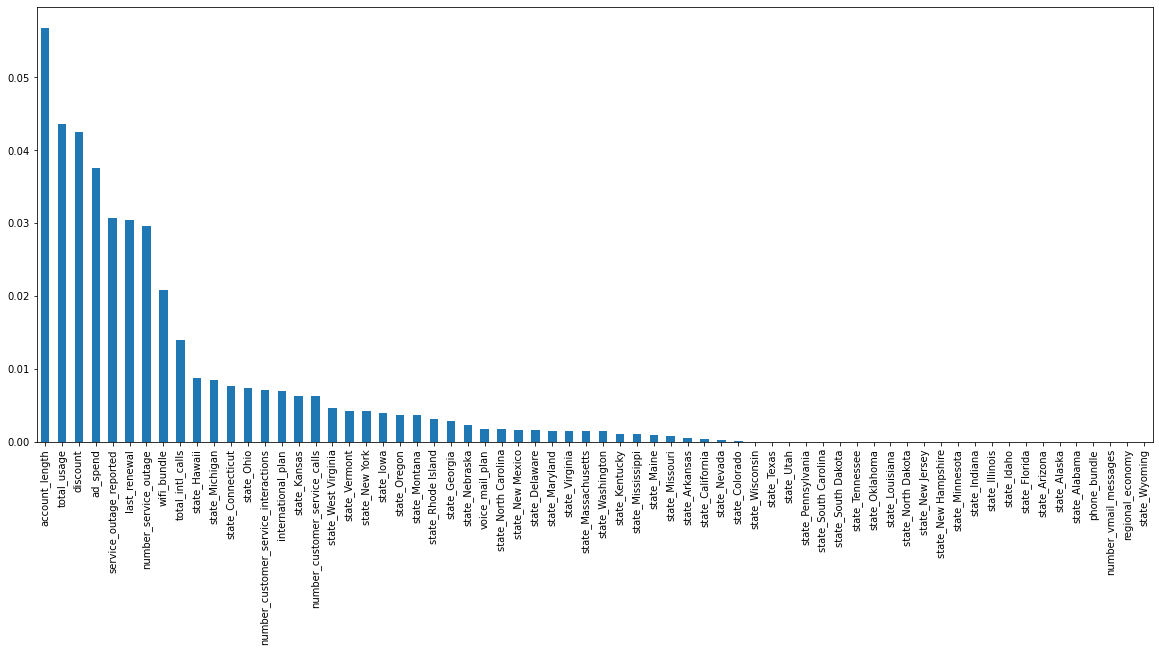

In [34]:
# Plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [17]:
# Only select those 26 variables
columns = ["account_length", "total_usage", "discount", "ad_spend", "service_outage_reported",
           "number_service_outage", "last_renewal", "wifi_bundle", "total_intl_calls", "state_Minnesota","state_Wyoming",
           "number_customer_service_calls","state_Hawaii","number_customer_service_interactions","state_Idaho",
           "state_North Carolina", "state_South Dakota","state_West Virginia","state_Mississippi","state_Florida",
           "state_New York","state_Pennsylvania", "regional_economy","state_New Jersey","state_Kentucky",
           "number_vmail_messages","state_Tennessee","state_Colorado","state_Michigan", "state_Oregon","state_Delaware"]

In [18]:
# Create a new dataframe with the selected columns
data_new = X_train.loc[:, columns]
data_new = pd.concat([data_new, y_train], axis=1)

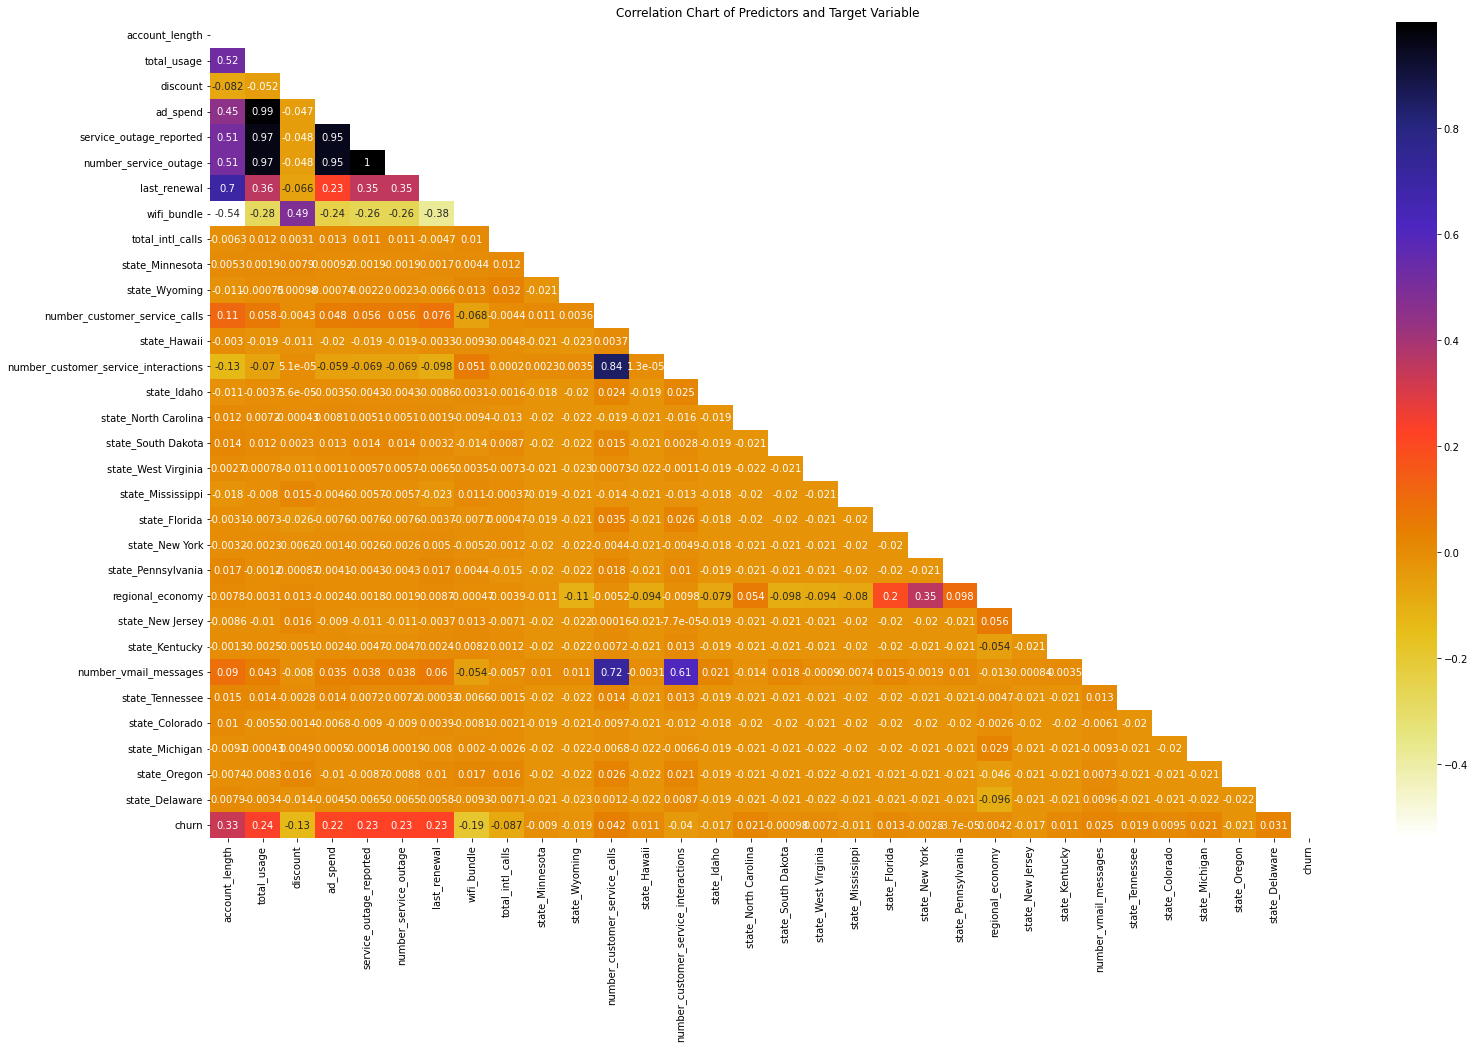

In [44]:
# Build a corelation matrix
plt.figure(figsize=(25, 15))
cor = data_new.corr()
mask = np.triu(np.ones_like(cor, dtype=bool))  # Create a mask for upper triangle
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r, mask=mask)
plt.title('Correlation Chart of Predictors and Target Variable')
plt.show()

In [90]:
# Calculate correlation between columns
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # We are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # Get the name of column
                col_corr.add(colname)
    return col_corr

In [91]:
# Select highly correlated features
corr_features = correlation(data_cor, 0.8)
corr_features

{'ad_spend',
 'number_customer_service_interactions',
 'number_service_outage',
 'service_outage_reported'}

> **Note:** The above features are highly correlated to each other, so these variables can be removed to reduce multicolinearity.
number_service_outage is highly correlated with total_usage and ad_spend, which have correlation scores of 0.24 and 0.22 respectively. Therefore we can remove ad_spend.

In [111]:
data_new = data_new.drop (["ad_spend","number_customer_service_interactions","number_service_outage","service_outage_reported"],axis=1)

In [112]:
data_new.shape

(10000, 28)

In [107]:
# Split the data into train and test sets
train_data, test_data = train_test_split(data_new, test_size=0.2, random_state=42)

# Assign the IVs and DV for train set
X=train_data.drop(["churn"], axis=1)
y=train_data["churn"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Assign the IVs and DV for test set
X_test=test_data.drop(["churn"], axis=1)
y_test=test_data["churn"]

In [20]:
train_data.churn.value_counts()

0    5126
1    2874
Name: churn, dtype: int64

## **Model Building**

In [115]:
# Initialize classifiers
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 1000)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
neuralNet    = MLPClassifier()

In [116]:
# Create a dictionaly of models
models = {"logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "neuralNet"    :neuralNet}

In [117]:
# Fit the models on the train set
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")

logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
neuralNet has been trained successfully


In [118]:
# Initialize dictionaries to store performance metrics
train_performances = {}
validation_performances = {}
test_performances = {}

# Train metrics
for model in models:
    predictions = models[model].predict(X_train)
    probabilities = pd.DataFrame(models[model].predict_proba(X_train))[1]
    accuracy = accuracy_score(y_train, predictions)
    auc = roc_auc_score(y_train, probabilities)
    precision = precision_score(y_train, predictions)
    recall = recall_score(y_train, predictions)
    train_performances[model] = {"Train Accuracy": accuracy, "Train AUC": auc, "Train Precision": precision, "Train Recall": recall}

# Validation metrics
for model in models:
    predictions = models[model].predict(X_val)
    probabilities = pd.DataFrame(models[model].predict_proba(X_val))[1]
    accuracy = accuracy_score(y_val, predictions)
    auc = roc_auc_score(y_val, probabilities)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    validation_performances[model] = {"Validation Accuracy": accuracy, "Validation AUC": auc, "Validation Precision": precision, "Validation Recall": recall}

# Test metrics
for model in models:
    predictions = models[model].predict(X_test)
    probabilities = pd.DataFrame(models[model].predict_proba(X_test))[1]
    accuracy = accuracy_score(y_test, predictions)
    auc = roc_auc_score(y_test, probabilities)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    test_performances[model] = {"Test Accuracy": accuracy, "Test AUC": auc, "Test Precision": precision, "Test Recall": recall}

# Combine metrics:
train=pd.DataFrame(train_performances)
validation=pd.DataFrame(validation_performances)
test=pd.DataFrame(test_performances)
result = train.append(validation).append(test)
result

logistic  randomForest  boostedTree  neuralNet
Train Accuracy        0.701875      1.000000     0.769375   0.693281
Train AUC             0.708161      1.000000     0.812029   0.708062
Train Precision       0.641281      1.000000     0.802334   0.597491
Train Recall          0.390889      1.000000     0.477223   0.454664
Validation Accuracy   0.706250      0.736875     0.741875   0.706250
Validation AUC        0.701774      0.725588     0.754340   0.702838
Validation Precision  0.635616      0.704420     0.732143   0.609756
Validation Recall     0.407733      0.448155     0.432337   0.483304
Test Accuracy         0.691000      0.733000     0.741000   0.691000
Test AUC              0.696037      0.740270     0.760509   0.699371
Test Precision        0.640000      0.715499     0.740659   0.609174
Test Recall           0.369064      0.457259     0.457259   0.450475

> **Note:** The Gradient Boosted Tree is the best performing model, having the highest test AUC of 0.76 and a train AUC of 0.81. Looking at Recall, randomForest has the highest score but also has a train Recall score of 1, which implies that there is overfitting. So we can confirm that the best model is Gradient Boosted Tree, over all other models with a test Recall score of 0.457 and train Recall score of 0.478. so we are selecting boosting and logistic regrression for further analysis

## **Fisher score feature selction **


##### to reduce overfitting and increase auc/recall

In [119]:
# Create SelectKBest instance with f_classif
selector = SelectKBest(score_func=f_classif, k='all')

# Fit selector to X_train and y_train
selector.fit(X_train, y_train)

# Get F-scores and corresponding feature names
f_scores = selector.scores_
feature_names = X_train.columns

# Sort the F-scores and feature names in descending order
sorted_indices = np.argsort(f_scores)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]

# Select the top 15 variables based on the F-scores
top_15_features = sorted_features[:15]

# Print the top 15 variables based on the F-scores
print("Top 15 Variables based on F-score:")
for feature in top_15_features:
    print(feature)

Top 15 Variables based on F-score:
account_length
total_usage
last_renewal
wifi_bundle
discount
total_intl_calls
number_customer_service_calls
state_Delaware
state_Michigan
state_West Virginia
state_North Carolina
state_Idaho
state_New Jersey
state_Florida
number_vmail_messages


In [108]:
# Select the top 15 varibles from fisher score

#columns_to_select= top_15_features

columns_to_select = [
    'account_length',
    'total_usage',
    'last_renewal',
    'wifi_bundle',
    'discount',
    'total_intl_calls',
    'number_customer_service_calls',
    'state_Delaware',
    'state_Michigan',
    'state_West Virginia',
    'state_North Carolina',
    'state_Idaho',
    'state_New Jersey',
    'state_Florida',
    'number_vmail_messages'
]

# Rest of the code...


X_train=X_train.loc[:,columns_to_select]
X_test= X_test.loc[:,columns_to_select]

# Assign IVs and DV for the train set
#X=train_data.drop(["churn"], axis=1)
#y=train_data["churn"]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Assign IVs and DV for the test set
#X_test=test_data.drop(["churn"], axis=1)
#y_test=test_data["churn"]

####  Retrain and Hypertune the model

In [109]:
from sklearn.linear_model import LogisticRegression

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the logistic regression model
logistic = LogisticRegression(max_iter=1000)
class_weight = {0:1, 1:5}

# Define the hyperparameters to tune
param_grid = {
    'C': [0.01, 0.1, 0.4, 0.8, 0.3],  # Regularization parameter
    'penalty': ['l1'],  # Regularization type
    'class_weight': [None, 'balanced'],
    'solver': ['liblinear', 'lbfgs']  # Class weights
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(logistic, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

# Evaluate the best model on the train set
y_pred_train = best_model.predict_proba(X_train)[:, 1]  # Predict probabilities of positive class
predictions_train = best_model.predict(X_train)
auc_score_train = roc_auc_score(y_train, y_pred_train)
accuracy_train = accuracy_score(y_train, predictions_train)
precision_train = precision_score(y_train, predictions_train)
recall_train = recall_score(y_train, predictions_train)
f1_score_train = f1_score(y_train, predictions_train)

# Evaluate the best model on the validation set
y_pred_val = best_model.predict_proba(X_val)[:, 1]  # Predict probabilities of positive class
predictions_val = best_model.predict(X_val)
auc_score_val = roc_auc_score(y_val, y_pred_val)
accuracy_val = accuracy_score(y_val, predictions_val)
precision_val = precision_score(y_val, predictions_val)
recall_val = recall_score(y_val, predictions_val)
f1_score_val = f1_score(y_val, predictions_val)

# Evaluate the best model on the test set
y_pred_test = best_model.predict_proba(X_test)[:, 1]  # Predict probabilities of positive class
predictions_test = best_model.predict(X_test)
auc_score_test = roc_auc_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, predictions_test)
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)
f1_score_test = f1_score(y_test, predictions_test)

# Create a dataframe to store the results
results_df = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'AUC Score': [auc_score_train, auc_score_val, auc_score_test],
    'Accuracy': [accuracy_train, accuracy_val, accuracy_test],
    'Precision': [precision_train, precision_val, precision_test],
    'Recall': [recall_train, recall_val, recall_test],
    'F1 Score': [f1_score_train, f1_score_val, f1_score_test]
})

# Print the results dataframe
results_df

Best Hyperparameters: {'C': 0.8, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


Dataset  AUC Score  Accuracy  Precision    Recall  F1 Score
0       Train   0.708824  0.663086   0.524281  0.608315  0.563181
1  Validation   0.721216  0.665625   0.544954  0.622642  0.581213
2        Test   0.703005  0.653000   0.525935  0.591588  0.556833

> **Note:** We see that recall and precision have been increased compared to the earlier model and the overfitting issue has been resolved.

## **Interpretation**

### 1. Logistic Regression

In [126]:
# Calculating the coefficients for the best model
df_coef = pd.DataFrame(best_model.coef_, columns=X_train.columns)
df_coef["INTERCEPT"] = best_model.intercept_
df_coef

account_length  total_usage  last_renewal  wifi_bundle  discount  \
0        0.038287     0.041268     -0.000308     0.025177 -3.123742   

   total_intl_calls  number_customer_service_calls  state_Delaware  \
0         -0.112807                      -0.017027        0.359855   

   state_Michigan  state_West Virginia  state_North Carolina  state_Idaho  \
0        0.395462             0.362994              0.164865     -0.24604   

   state_New Jersey  state_Florida  number_vmail_messages  INTERCEPT  
0         -0.029939       0.385243              -0.026799  -1.078511

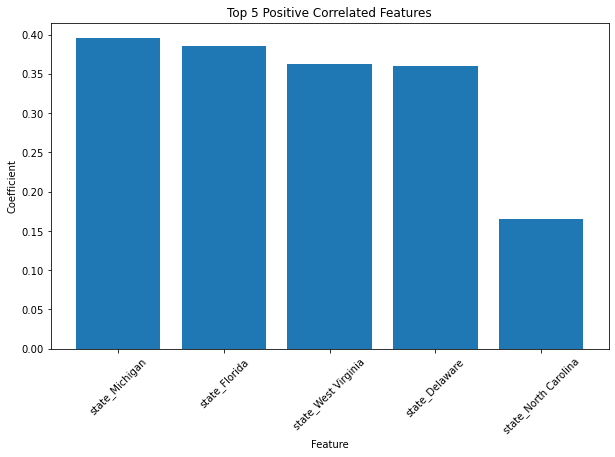

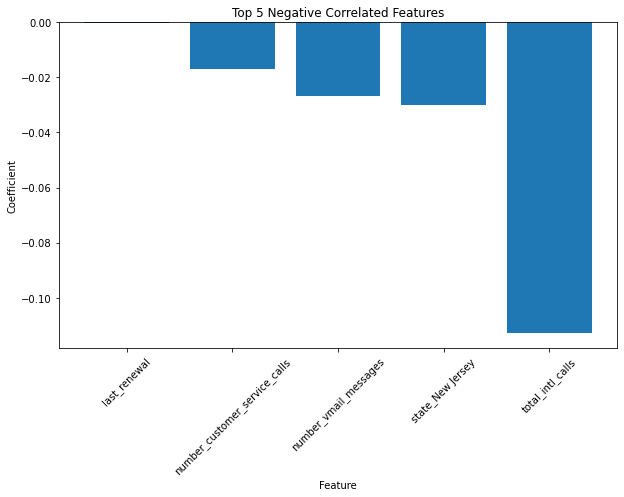

In [127]:
# Sort the coefficients

# Convert dataframe to long format
df_coef_long = pd.melt(df_coef, value_vars=df_coef.columns[:-1], var_name='Feature', value_name='Coefficient')

# Sort the dataframe by the coefficient
df_coef_long.sort_values(by='Coefficient', ascending=False, inplace=True)

# Select top 5 positive correlated features
top_positive = df_coef_long[df_coef_long['Coefficient'] > 0].head(5)

# Select top 5 negative correlated features
top_negative = df_coef_long[df_coef_long['Coefficient'] < 0].head(5)

# Generate plots for top positive correlated features
plt.figure(figsize=(10, 6))
plt.bar(top_positive['Feature'], top_positive['Coefficient'])
plt.title('Top 5 Positive Correlated Features')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.show()

# Generate plots for top negative correlated features
plt.figure(figsize=(10, 6))
plt.bar(top_negative['Feature'], top_negative['Coefficient'])
plt.title('Top 5 Negative Correlated Features')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.show()

**Note:**

Top 5 positive coefficients:
- `state_Michigan`: An increase in the likelihood of the positive class by approximately 43.3% if the customer is from Michigan.
- `state_Florida`: An increase in the likelihood of the positive class by approximately 23.0% if the customer is from Florida.
- `state_West Virginia`: An increase in the likelihood of the positive class by approximately 28.2% if the customer is from West Virginia.
- `state_Delaware`: An increase in the likelihood of the positive class by approximately 38.8% if the customer is from Delaware.
- `state_North Carolina`: An increase in the likelihood of the positive class by approximately 16.1% if the customer is from North Carolina.

Top 3 negative coefficients:
- `total_intl_calls`: A decrease in the likelihood of the positive class by approximately 11.0% for each additional international call made.
- `state_New Jersey`: A decrease in the likelihood of the positive class by approximately 2.9% if the customer is from New Jersey.
- `number_vmail_messages`: A decrease in the likelihood of the positive class by approximately 2.7% for each additional voice mail.

In [128]:
# Convert logit to probability
def logit_to_prob(logit):
    return 1/(1+np.exp(-logit))

logit_to_prob(df_coef["INTERCEPT"]).round(3) 

0    0.254
Name: INTERCEPT, dtype: float64

> **Note:** In the absence of any other information or predictors, the estimated probability of the positive class is 0.254

#### Partial Dependency Plot (PDP)

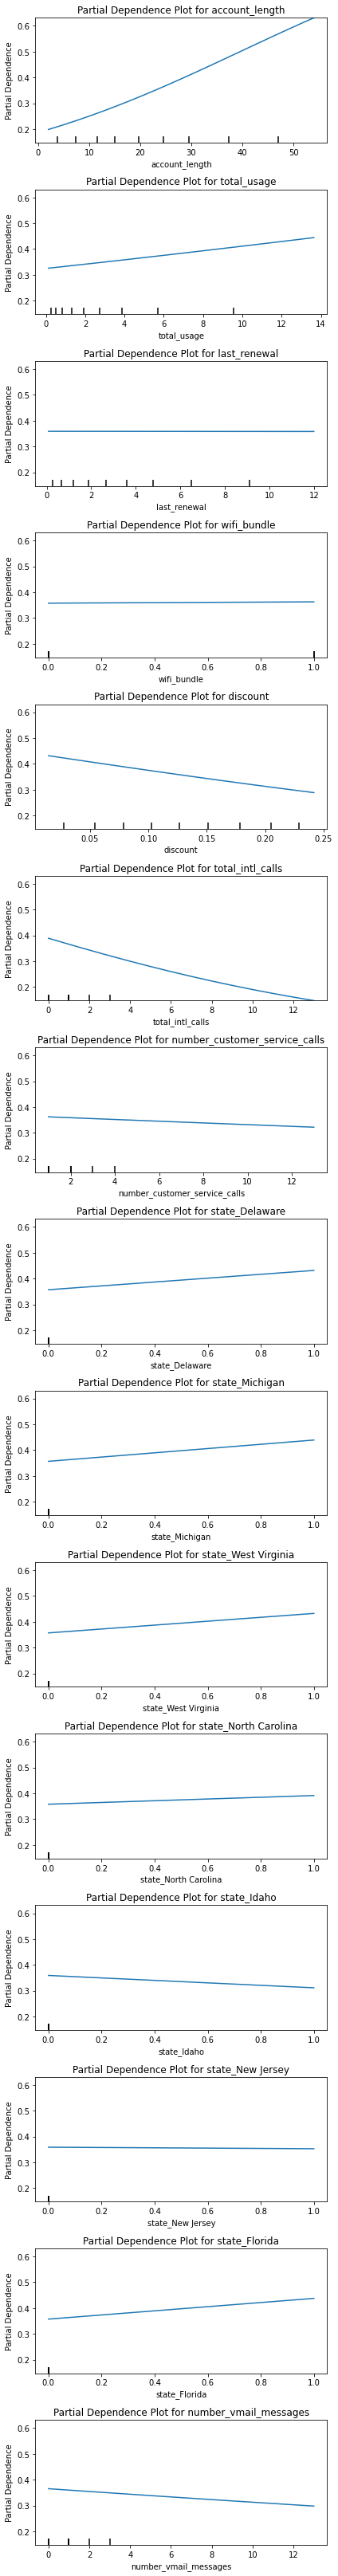

In [131]:
# Partial plot for top 15 features 
feature_names = top_15_features

fig, ax = plt.subplots(len(feature_names), 1, figsize=(6, len(feature_names) * 3))
plot_partial_dependence(best_model, X_train, features=list(range(0, len(feature_names))), feature_names=feature_names, ax=ax)

# Set the title and axis labels for each subplot
for i, feature_name in enumerate(feature_names):
    ax[i].set_title(f'Partial Dependence Plot for {feature_name}')
    ax[i].set_xlabel(feature_name)
    ax[i].set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

> **Note:**  
> - account_lenght is positively correlated with the target variable "churn". The longer the lenght of the account, i.e. the higher the LOR of the customer,  the higher the probability to churn.
> - total_intl_calls is negatively correlcated with the target variable "churn". The more the number of international calls the customers makes, the less likely they are to churn.
> - total_usage, state_Delaware, state_Michigan, state_West Virginia, State_ North Carolina, and State_Florida are positively correlated with the target variable, customers from these states tend to chirn more ,but the extend of the impact is not that larger as they have a flatter line.
> - discount, number_customer_service_calls, state_idaho and number_vmail_messages are negatively correlated with the target variable, but the extend of the impact is lower as they have a flatter line.
> - last_renewal, wifi_bundle, and State_New Jersey do not impact the model very significantly, as they have a flat line.

#### Individual Consitional Expectation Plot (ICE)

Text(0.5, 0.98, 'XGBoost')

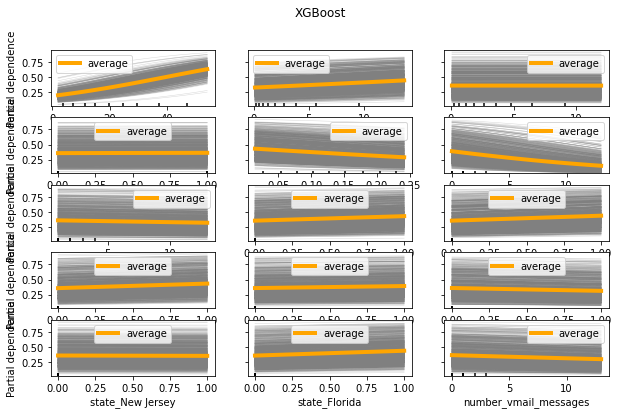

In [138]:
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    estimator=best_model,
    X=X_train,
    features=list(range(0, len(feature_names))),
    #target=list(iris.target_names).index(target_name),
    kind="both",
    ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
    pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
    # centered=True,
    ax=ax
    )
#fig.tight_layout(pad=2.0)
fig.suptitle("XGBoost")

> **Note:** The ICE plots confirm that the PDP plot results are valid. it follows the same trend as partial plots

#### 2D - Partial Plot

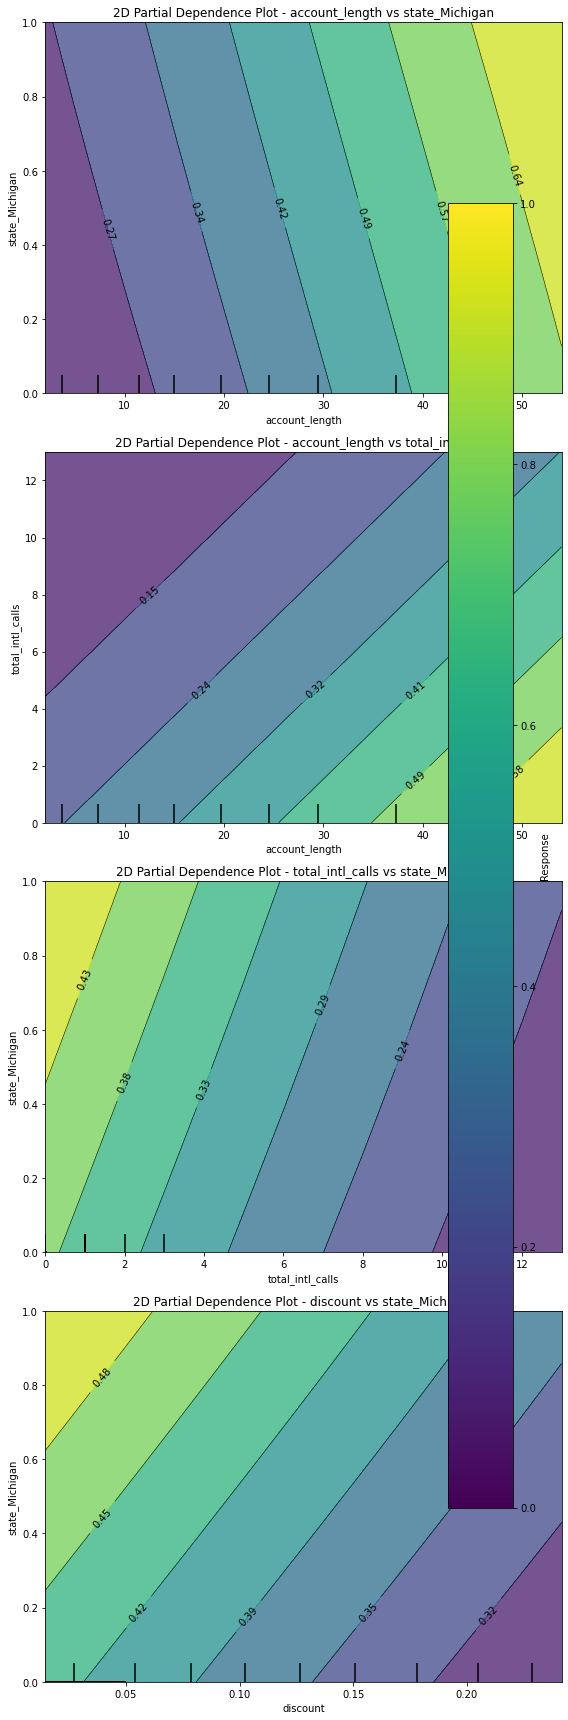

In [141]:
# Define the feature combinations for the 2D partial dependence plots
feature_combinations = [(0, 8), (0, 5), (5, 8), (4, 8)]  # Example feature indices

# Plot the 2D partial dependence plots
fig, ax = plt.subplots(len(feature_combinations), 1, figsize=(8, len(feature_combinations) * 6))

for i, feature_pair in enumerate(feature_combinations):
    plot_partial_dependence(best_model, X_train, features=[feature_pair], feature_names=feature_names, ax=ax[i])

    # Set the title and axis labels for each subplot
    ax[i].set_title(f'2D Partial Dependence Plot - {feature_names[feature_pair[0]]} vs {feature_names[feature_pair[1]]}')
    ax[i].set_xlabel(feature_names[feature_pair[0]])
    ax[i].set_ylabel(feature_names[feature_pair[1]])

# Add a color legend
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Response')

plt.tight_layout()
plt.show()

> **Note:** 
> - state_Michigan vs. account_lenght: Michigan customers tend to churn more quickly than other state residents. For example, if someone is from Michigan, the probability of customer churn is 49% when the length of the customer relationship is around 30 months. On the other hand, customers from other states tend to stay longer, with an average relationship length of around 40 months before reaching a 49% probability of churn.
> - state_Michigan vs. discount: Michigan customers are less likely to churn as discount increases. However they still churn at a higher rate than customers from other states. For example, if someone is from Michigan, the probability of customer churn is 40% percent when the discount is around 20%. On the other hand, customers from other states have a churn rate of less than 32%.
> - state_Michigan vs. Total intcall: Michigan customers are less likely to churn as they make more number of interantinal calls. For example, if someone is from Michigan, the probability of customer churn is 29% even when the number of calls are more than 8. As num of calls increases to 12 the probabilty drops to just 20%.

#### LIME

In [110]:
categorical_features = ["wifi_bundle", "state_Michigan", "state_Delaware","state_West Virginia","state_North Carolina", 
                        "state_Idaho", "state_New Jersey", "state_Florida"]
categorical_features = [list(X_train.columns).index(i) for i in categorical_features]

#class_names = [" churn=0", "non churn=1"]

# Initialize explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    discretize_continuous=True,
    feature_names=list(X_train.columns),
    mode="classification",
    sample_around_instance=True
    )

# Explain first instance in test set
exp = explainer.explain_instance(X_test.iloc[1], best_model.predict_proba,num_features=len(X_train.columns))
exp.show_in_notebook(show_table=True, show_all=True)

> **Note:**  The above image shows three graphs that each show essential information about customers and their churn rates:
> - The left graph shows that sample 1 in the data shows the confidence interval stating that this instance is 63% Churn.
> - In the center graph, we can observe the feature importance scores for this specific sample. Account_length has the highest importance score of 27%, indicating that it contributes significantly to the predicted churn probability. Total_usage follows with a feature importance score of 9%, suggesting that higher total usage is associated with an increased churn probability. Other factors that contribute to the churn probability include the total_intl_calls and being from states like Idaho and New Jersey. On the other hand, the discount variable has a negative importance score of 10%, indicating that an increase in discount may reduce the churn probability. Furthermore, customers who are not from Delaware, Florida, and Virginia tend to have a lower churn probability. Overall, account length, total usage, discount, and the customer's state play significant roles in determining the churn probability for this specific instance.
> - The right graph shows the 15 features and their respective values. The features highlighted in orange contribute toward class 1 (Churn) whereas features highlighted in blue contribute toward class 0 (Not Churn).

In [111]:
# Display Model prediction vs LIME prediction
pd.DataFrame(
    [exp.local_pred.item(), exp.predict_proba[1]],
    index=["LIME Prediction", "Model Prediction"],
    columns=["Probability"]
    )

Probability
LIME Prediction       0.69970
Model Prediction      0.74574

> **Explanation:** Comparing the LIME prediction  and the model prediction, we can observe that lime probability is lower than the  probability of model but still we can classify it as churn class . However, it's important to note that LIME predictions are approximations and may not perfectly reflect the model's predictions. It's also worth considering that LIME provides local interpretability, focusing on individual instances, while the model prediction represents the overall behavior of the model. Therefore, the LIME prediction can help provide insights into the factors influencing the model's decision for the specific instance being analyzed.

In [112]:
# Display coefficients of LIME local regression model

# Sort coefficients according to index  
coef = exp.local_exp[1]
coef = sorted(coef)

# Create dataframe and merge intercept
df_coef = pd.DataFrame([i[1] for i in coef], columns=["beta"], index=X_train.columns)
df_coef = pd.concat((df_coef, pd.Series(exp.intercept[1], index=["INTERCEPT"], name="beta").to_frame()))

df_coef

beta
account_length                 0.275995
total_usage                    0.091863
last_renewal                  -0.016735
wifi_bundle                   -0.002642
discount                      -0.098672
total_intl_calls               0.063257
number_customer_service_calls -0.001521
state_Delaware                -0.085560
state_Michigan                -0.092813
state_West Virginia           -0.088711
state_North Carolina          -0.042595
state_Idaho                    0.055655
state_New Jersey               0.038479
state_Florida                 -0.055824
number_vmail_messages          0.013197
INTERCEPT                      0.646325

> **Explanation:** The beta values represent the weights or coefficients assigned to each feature in the LIME explanation. These weights indicate the contribution of each feature towards the predicted outcome. By considering the feature weights, we can see that account_length has the highest and a positive impact on the prediction, followed by total_usage. On the other hand, state_West Virginia has the highest negative impact on customer churn.

In [113]:
# Display attribution table
pd.DataFrame(exp.as_list(),columns=['Feature','Attribution'])

Feature  Attribution
0                  account_length > 33.00     0.275995
1                         discount > 0.19    -0.098672
2                  state_Michigan <= 0.00    -0.092813
3                      total_usage > 4.75     0.091863
4             state_West Virginia <= 0.00    -0.088711
5                  state_Delaware <= 0.00    -0.085560
6                total_intl_calls <= 1.00     0.063257
7                   state_Florida <= 0.00    -0.055824
8                     state_Idaho <= 0.00     0.055655
9            state_North Carolina <= 0.00    -0.042595
10               state_New Jersey <= 0.00     0.038479
11                    last_renewal > 5.47    -0.016735
12          number_vmail_messages <= 0.00     0.013197
13                    wifi_bundle <= 0.00    -0.002642
14  number_customer_service_calls <= 1.00    -0.001521

#### SHAP

In [26]:
# Set up explainer for ".predict" method
explainer = shap.Explainer(best_model.predict, X_train)

# Compute shap values
shap_values = explainer(X_train)

Permutation explainer: 5121it [04:36, 18.20it/s]                                                                       


In [27]:
# Check explainer type
print(str(explainer)) # make sure your are using the intended explainer

# Check explainer type
print(str(explainer.masker))

shap.explainers.Permutation()


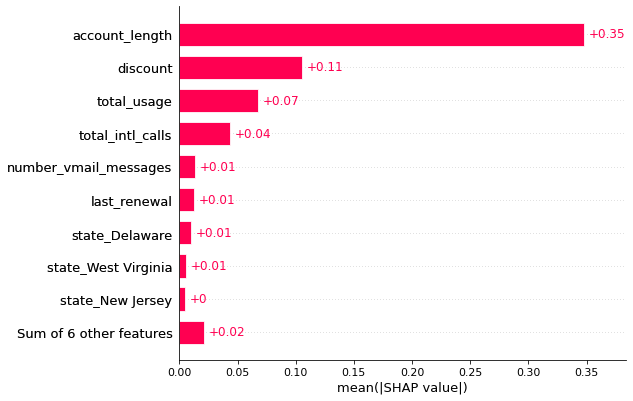

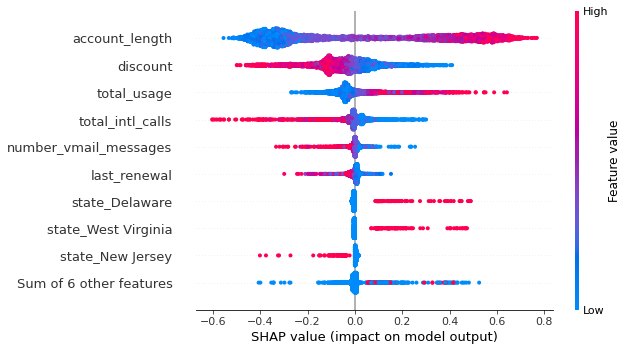

In [28]:
# Feature importance (global)

# Bar chart
shap.plots.bar(shap_values)

# Individual dots for each instance
shap.plots.beeswarm(shap_values)

> **Interpretation:** account length , discount, total international calls, total usage are the top features which contribute more to churn prediction with the higher shap coeffcients/values. The rest of varibles have almost similar shap values 0.01.

> **Note:** Red indicates high impact on predicting churn probablity and blue indicates low impact of variable on churn probabilty.
> 1. Discount: A high positive SHAP value for the "Discount" feature indicates that providing more discounts has a high impact on reducing customer churn. It suggests that customers are more likely to stay for a longer duration if they receive more discounts. Conversely, a low or negative SHAP value for "Discount" implies that the absence or reduced availability of discounts impacts churn negatively, increasing the likelihood of customers churning.
> 2. Account Length:  A positive SHAP value for "account_length" indicates that, after a certain period since the account opening, customers tend to churn more. This suggests that long-term customers may become more likely to churn over time and new customers are less likely to churn.
> 3. Total Usage:  A positive SHAP value for "total_ usage" suggests that, as the total usage increases, it positively impacts the probability of customer churn. This implies that a higher usage may lead to more churners.
> 4. Last Renewal: if number months since las renewal contract is less, then customer churn is less likely to happen.
> 5. State (west virginia, Delaware, and North Carolina):  positive SHAP value for states like virginia and Delaware indicates  that customers from these states have a higher impact on the probability of churn. This implies that customers from these states are more likely to churn. On the other hand, new jersy customers have less churn probabaility
> 6) number of voice messages : if number of voice message sent is more, it  decreases the churn probabilty 
> **Conclusion:** In conclusion, offering discounts, nurturing long-term customer relationships, managing usage patterns,
ensuring timely renewals, and targeting specific states can help mitigate churn and improve customer retention. Additionally, leveraging communication channels, such as voice messages, may positively impact customer loyalty.

In [30]:
# Set up kernel explainer for ".predict_proba" method
explainer = shap.KernelExplainer(best_model.predict_proba, shap.sample(X_train, 50))

# Compute SHAP values
shap_values = explainer.shap_values(X_train)


  0%|          | 0/5120 [00:00<?, ?it/s]

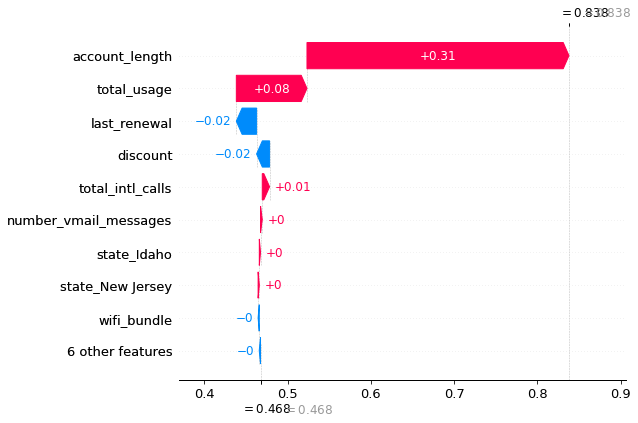

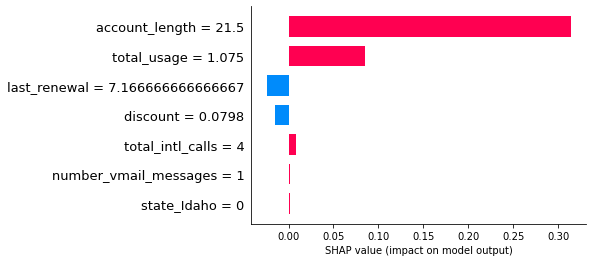

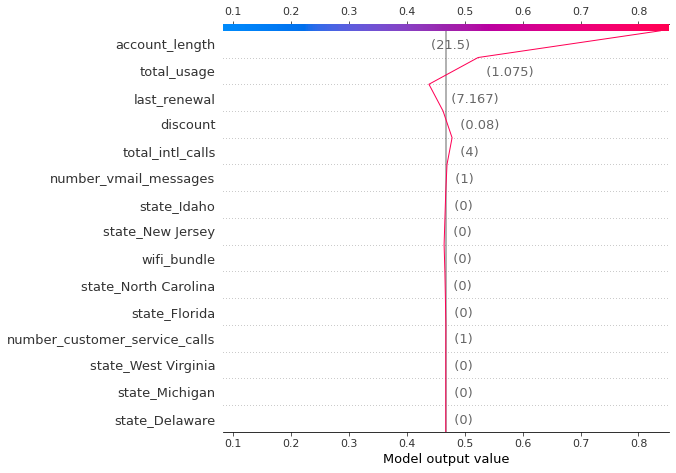

In [32]:
# Feature importance for individual instances (and class)

target = 1
instance = 0

# Inspect feature contributions for individual instances
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[target], shap_values[target][instance], feature_names=X_test.columns)

# Bar plot for individual instances
shap.bar_plot(shap_values[target][instance], X_test.iloc[instance])

# Decision plot for individual instances
shap.decision_plot(explainer.expected_value[target], shap_values[target][instance], X_test)

shap.force_plot(explainer.expected_value[target], shap_values[target][instance], X_test.iloc[instance])

> **Note:** In the specific instance where the predicted probability of customer churn is 0.838, several factors contribute to the churn probability. The churn probability remains constant at 0.468 if the customer is not from Delaware, Michigan, Virginia, Florida, New Jersey, and a few other states. The probability of churn slightly increases based on the number of international calls (4), but it decreases again due to the presence of a discount and recent contract renewal. The churn probability jumps drastically with variables like average monthly usage and account length, indicating that higher values for these variables contribute to classifying the instance as churn.

> In conclusion, for this particular instance, factors such as the customer's state, international call usage, discount availability, recent contract renewal, average monthly usage, and account length significantly influence the churn probability. Identifying these factors and their impact on churn probability can help businesses develop targeted strategies to mitigate churn and improve customer retention.

### 2. Gradient Boosting Tree

In [117]:
import pandas as pd
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the gradient boosting model
gradient_boosting = GradientBoostingClassifier()

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [150, 200, 300],  # Number of trees
    'learning_rate': [0.1,0.03, 0.05, 0.01],  # Learning rate
    'max_depth': [ 4, 8],  # Maximum depth of trees
    'min_samples_split': [5,8,10],  # Minimum number of samples required to split a node
}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(gradient_boosting, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model_gbt = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

# Evaluate the best model on the train set
y_pred_train = best_model_gbt.predict_proba(X_train)[:, 1]  # Predict probabilities of positive class
predictions_train = best_model_gbt.predict(X_train)
auc_score_train = roc_auc_score(y_train, y_pred_train)
accuracy_train = accuracy_score(y_train, predictions_train)
precision_train = precision_score(y_train, predictions_train)
recall_train = recall_score(y_train, predictions_train)
f1_score_train = f1_score(y_train, predictions_train)

# Evaluate the best model on the validation set
y_pred_val = best_model_gbt.predict_proba(X_val)[:, 1]  # Predict probabilities of positive class
predictions_val = best_model_gbt.predict(X_val)
auc_score_val = roc_auc_score(y_val, y_pred_val)
accuracy_val = accuracy_score(y_val, predictions_val)
precision_val = precision_score(y_val, predictions_val)
recall_val = recall_score(y_val, predictions_val)
f1_score_val = f1_score(y_val, predictions_val)

# Evaluate the best model on the test set
y_pred_test = best_model_gbt.predict_proba(X_test)[:, 1]  # Predict probabilities of positive class
predictions_test = best_model_gbt.predict(X_test)
auc_score_test = roc_auc_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, predictions_test)
precision_test = precision_score(y_test, predictions_test)
recall_test = recall_score(y_test, predictions_test)
f1_score_test = f1_score(y_test, predictions_test)

# Create a dataframe to store the results
results_df_bst = pd.DataFrame({
    'Dataset': ['Train', 'Validation', 'Test'],
    'AUC Score': [auc_score_train, auc_score_val, auc_score_test],
    'Accuracy': [accuracy_train, accuracy_val, accuracy_test],
    'Precision': [precision_train, precision_val, precision_test],
    'Recall': [recall_train, recall_val, recall_test],
    'F1 Score': [f1_score_train, f1_score_val, f1_score_test]
})

results_df_bst

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_split': 8, 'n_estimators': 300}


Dataset  AUC Score  Accuracy  Precision    Recall  F1 Score
0       Train   0.797421  0.765039   0.818552  0.439278  0.571734
1  Validation   0.774702  0.742969   0.791339  0.421384  0.549932
2        Test   0.755419  0.735500   0.750000  0.423338  0.541197

we see that no much improvemnt in auc and recall, but precisiona nd accuracy has been increased after hypertuning,and still performs has best model

#### Feature Importance

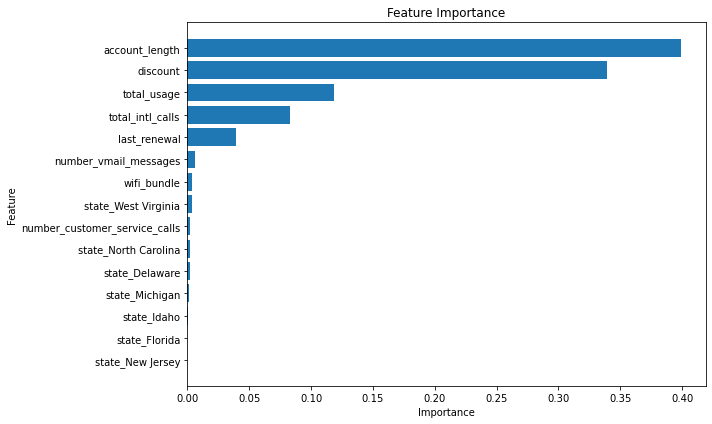

In [118]:
# Get the feature importances from the best model
feature_importances = best_model_gbt.feature_importances_

# Create a pandas DataFrame to store the feature importances along with the corresponding feature names
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame in descending order of feature importance
importance_df = importance_df.sort_values('Importance', ascending=True)

# Plot a horizontal bar graph of the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

> **Note:** account length, discount, total usage, total international calls, and last renewal are the significant influential variables in predicting customer churn. Among them, account length and discount have the highest impact on churn probability, followed by total usage, international calls, and last renewal. States like Michigan and Delaware have a slight effect on churn, while the impact of other states can be ignored.

#### Partial Dependency Plot (PDP)

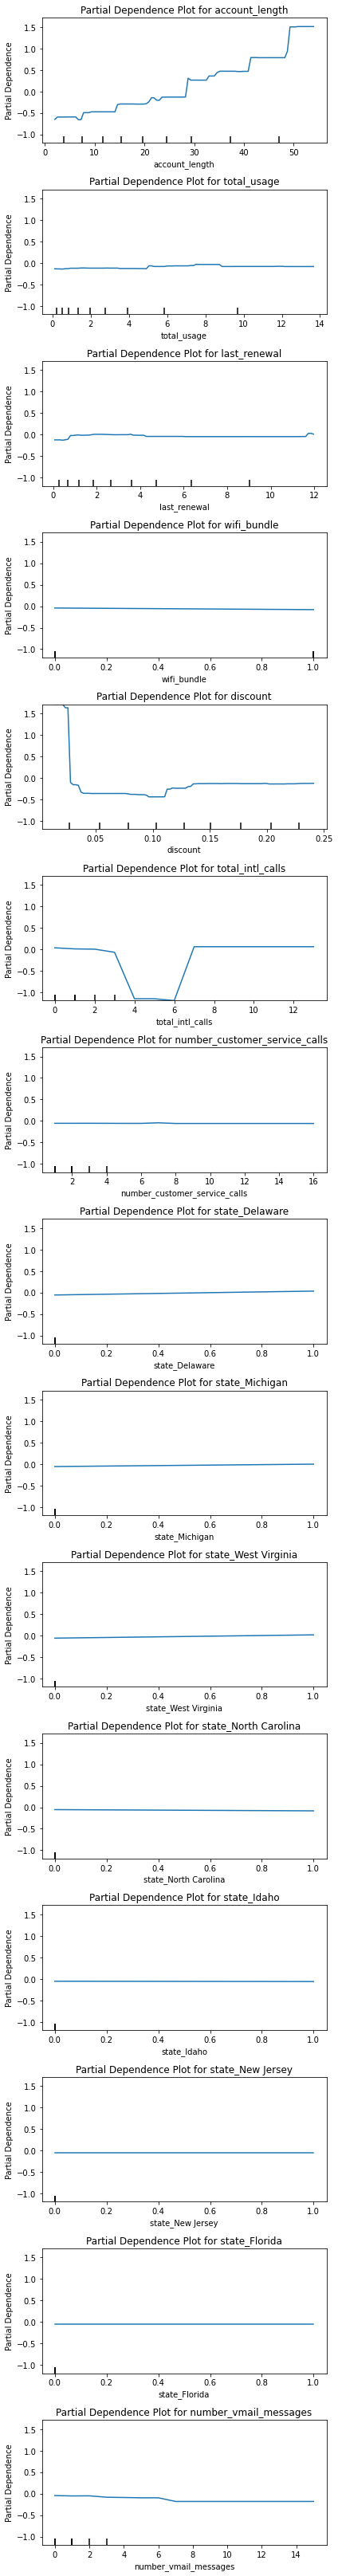

In [35]:
# Partial plot for top 15 features 

#feature_names = top_15_features
feature_names = [
    'account_length',
    'total_usage',
    'last_renewal',
    'wifi_bundle',
    'discount',
    'total_intl_calls',
    'number_customer_service_calls',
    'state_Delaware',
    'state_Michigan',
    'state_West Virginia',
    'state_North Carolina',
    'state_Idaho',
    'state_New Jersey',
    'state_Florida',
    'number_vmail_messages'
]

fig, ax = plt.subplots(len(feature_names), 1, figsize=(6, len(feature_names) * 3))
plot_partial_dependence(best_model_gbt, X_train, features=list(range(0, len(feature_names))), feature_names=feature_names, ax=ax)

# Set the title and axis labels for each subplot
for i, feature_name in enumerate(feature_names):
    ax[i].set_title(f'Partial Dependence Plot for {feature_name}')
    ax[i].set_xlabel(feature_name)
    ax[i].set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

> **Note:**  
> - account_lenght is positively correlated with the target variable "churn". The longer the lenght of the account, i.e. the higher the LOR of the customer,  the higher the probability to churn. We also notice that here the plot is a little like a step function and that's because we are using a tree based model. 
> - we can observe that higer the discount rate probabilty of customer churn is low, however it gets stabilized after certain dicount value.
> - total_intl_calls starts off with a flat line, then drops for values from 2 to 4 and then picks up to where it was earlier and continues to remain a flat line after that. we dont ahve any clear impact on the customer churn, we see that if the internal calls aroun 4 to 6 , the churn proabaility is very low, but increase in class after this also indicates bit raise in churn probabilty.
> - total_usage, last_renewal, wifi_bundle, number_customer_service_calls, state_Delaware, state_Michigan, state_West Virginia, state_North Carolina, state_Idaho, state_New Jearsey, state_Florida, number_vail_messages all have pretty much flat lines but or  or with  very slightly positively inclines, indicates these have slight imact on churn probability.

#### Individual Consitional Expectation Plot (ICE)

Text(0.5, 0.98, 'Gradient boosting')

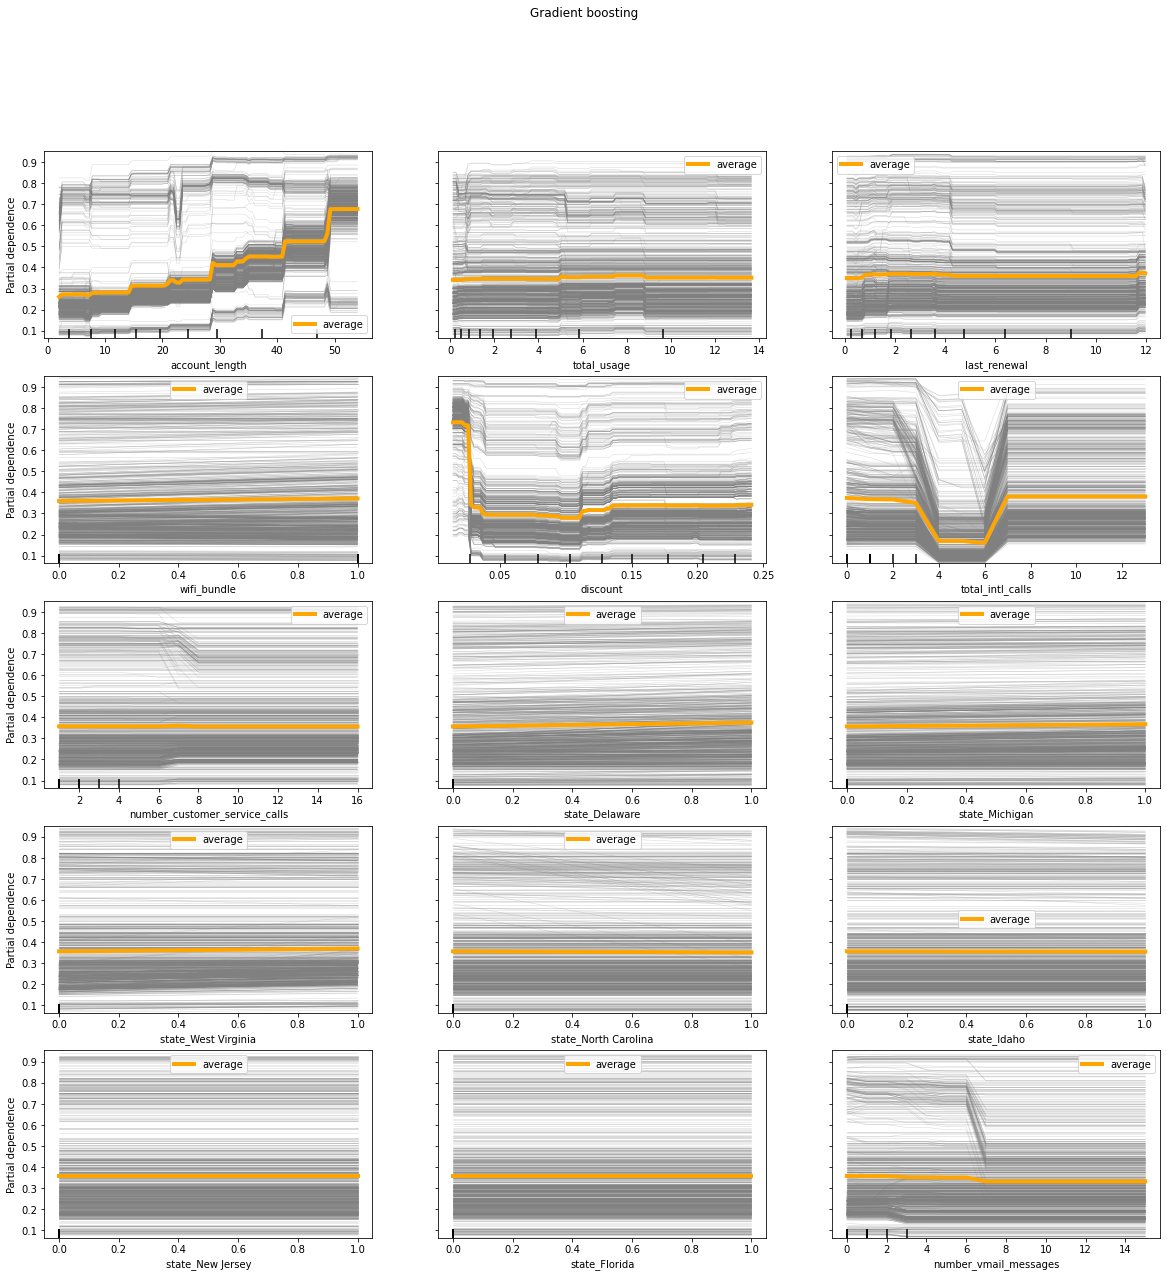

In [121]:
fig, ax = plt.subplots(figsize=(20, 20))
PartialDependenceDisplay.from_estimator(
    estimator=best_model_gbt,
    X=X_train,
    features=list(range(0, len(feature_names))),
    #target=list(iris.target_names).index(target_name),
    kind="both",
    ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
    pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
    # centered=True,
    ax=ax
    )
#fig.tight_layout(pad=2.0)
fig.suptitle("Gradient boosting")

> **Note:**  
> -  Most of the ICE plots confirm that the PDP plot results are valid, except for two. number_customer_service_calls has some different patterns that occur but one look at the PDP doesn't tell us anything about what's actually happening. The second one is number_vmail_messages. It too has the same issues as the other one. Just taking a look at the PDP could be a little misleading as it doen't capture all the patterns.

#### LIME

In [122]:
categorical_features = ["wifi_bundle", "state_Michigan", "state_Delaware","state_West Virginia","state_North Carolina", 
                        "state_Idaho", "state_New Jersey", "state_Florida"]
categorical_features = [list(X_train.columns).index(i) for i in categorical_features]

#class_names = [" churn=0", "non churn=1"]

# Initialize explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    discretize_continuous=True,
    feature_names=list(X_train.columns),
    mode="classification",
    sample_around_instance=True
    )

# Explain first instance in test set
exp = explainer.explain_instance(X_test.iloc[1], best_model_gbt.predict_proba,num_features=len(X_train.columns))
exp.show_in_notebook(show_table=True, show_all=True)


# Display Model prediction vs LIME prediction
pd.DataFrame(
    [exp.local_pred.item(), exp.predict_proba[1]],
    index=["LIME Prediction", "Model Prediction"],
    columns=["Probability"]
    )


# Display coefficients of LIME local regression model

# Sort coefficients according to index  
coef = exp.local_exp[1]
coef = sorted(coef)

# Create dataframe and merge intercept
df_coef = pd.DataFrame([i[1] for i in coef], columns=["beta"], index=X_train.columns)
df_coef = pd.concat((df_coef, pd.Series(exp.intercept[1], index=["INTERCEPT"], name="beta").to_frame()))

df_coef

# Display attribution table
pd.DataFrame(exp.as_list(),columns=['Feature','Attribution'])

Feature  Attribution
0                  account_length > 33.00     0.242854
1                      total_usage > 4.75     0.090275
2                total_intl_calls <= 1.00     0.061162
3                     state_Idaho <= 0.00    -0.039352
4             state_West Virginia <= 0.00    -0.030758
5            state_North Carolina <= 0.00    -0.023396
6                   state_Florida <= 0.00     0.017523
7                state_New Jersey <= 0.00     0.016714
8                  state_Delaware <= 0.00    -0.015039
9                     wifi_bundle <= 0.00    -0.011828
10                 state_Michigan <= 0.00    -0.009259
11                        discount > 0.19    -0.008074
12  number_customer_service_calls <= 1.00    -0.005605
13          number_vmail_messages <= 0.00    -0.002143
14                    last_renewal > 5.47     0.001585

> **Note:**  The above image shows three graphs that each show essential information about customers and their churn rates:
> - The left graph shows that sample 1 in the data shows the confidence interval stating that this instance is 67% Churn.
> - In the center graph, we can observe the feature importance scores for this specific sample. Account length has the highest importance score of 24%, indicating that it significantly contributes to the predicted churn probability. Total usage follows with a feature importance score of 9%, and total internal calls with 6%, suggesting that higher total usage and a high number of internal calls are associated with an increased churn probability. Other factors that contribute to the churn probability are states like Idaho, Virginia, Carolina, and other states, indicating a negative impact. Customers from these states tend to have a higher churn probability. Additionally, the graph highlights that higher discounts are associated with lower churn, indicating a negative effect of discounts on customer churn.
> - In the right graph, the 15 features and their respective values are displayed. The features highlighted in orange contribute to class 1 (Churn), while the features highlighted in blue contribute to class 0 (Not Churn).

In [126]:
# Display Model prediction vs LIME prediction
pd.DataFrame(
    [exp.local_pred.item(), exp.predict_proba[1]],
    index=["LIME Prediction", "Model Prediction"],
    columns=["Probability"]
    )

Probability
LIME Prediction      0.625514
Model Prediction     0.665361

> **Explanation:** Comparing the LIME prediction and the model prediction, we can observe that both probabilities are more or less the same, indicating a likelihood of the instance belonging to the predicted class. However, it's important to note that LIME predictions are approximations and may not perfectly reflect the model's predictions. It's also worth considering that LIME provides local interpretability, focusing on individual instances, while the model prediction represents the overall behavior of the model. Therefore, the LIME prediction can help provide insights into the factors influencing the model's decision for the specific instance being analyzed.

In [124]:
# Display coefficients of LIME local regression model

# Sort coefficients according to index  
coef = exp.local_exp[1]
coef = sorted(coef)

# Create dataframe and merge intercept
df_coef = pd.DataFrame([i[1] for i in coef], columns=["beta"], index=X_train.columns)
df_coef = pd.concat((df_coef, pd.Series(exp.intercept[1], index=["INTERCEPT"], name="beta").to_frame()))

df_coef

beta
account_length                 0.242854
total_usage                    0.090275
last_renewal                   0.001585
wifi_bundle                   -0.011828
discount                      -0.008074
total_intl_calls               0.061162
number_customer_service_calls -0.005605
state_Delaware                -0.015039
state_Michigan                -0.009259
state_West Virginia           -0.030758
state_North Carolina          -0.023396
state_Idaho                   -0.039352
state_New Jersey               0.016714
state_Florida                  0.017523
number_vmail_messages         -0.002143
INTERCEPT                      0.340854

**Explanation:** The beta values represent the weights or coefficients assigned to each feature in the LIME explanation. These weights indicate the contribution of each feature towards the predicted outcome. By considering the feature weights, we can see that account_length has the highest and a positive impact on the prediction, followed by total_usage. On the other hand, state_West Virginia has the highest negative impact on customer churn.

In [125]:
# Display attribution table
pd.DataFrame(exp.as_list(),columns=['Feature','Attribution'])

Feature  Attribution
0                  account_length > 33.00     0.242854
1                      total_usage > 4.75     0.090275
2                total_intl_calls <= 1.00     0.061162
3                     state_Idaho <= 0.00    -0.039352
4             state_West Virginia <= 0.00    -0.030758
5            state_North Carolina <= 0.00    -0.023396
6                   state_Florida <= 0.00     0.017523
7                state_New Jersey <= 0.00     0.016714
8                  state_Delaware <= 0.00    -0.015039
9                     wifi_bundle <= 0.00    -0.011828
10                 state_Michigan <= 0.00    -0.009259
11                        discount > 0.19    -0.008074
12  number_customer_service_calls <= 1.00    -0.005605
13          number_vmail_messages <= 0.00    -0.002143
14                    last_renewal > 5.47     0.001585

#### SHAP

In [42]:
# Set up explainer for ".predict" method
explainer = shap.Explainer(best_model_gbt.predict, X_train)

# Compute shap values
shap_values = explainer(X_train)


# check explainer type
print(str(explainer)) # make sure your are using the intended explainer

# check explainer type
print(str(explainer.masker))

# feature importance (global)

# bar chart
shap.plots.bar(shap_values)

# individual dots for each instance
shap.plots.beeswarm(shap_values)

Permutation explainer: 5121it [21:56,  3.86it/s]                                                                       


In [44]:

# check explainer type
print(str(explainer)) # make sure your are using the intended explainer

# check explainer type
print(str(explainer.masker))


shap.explainers.Permutation()


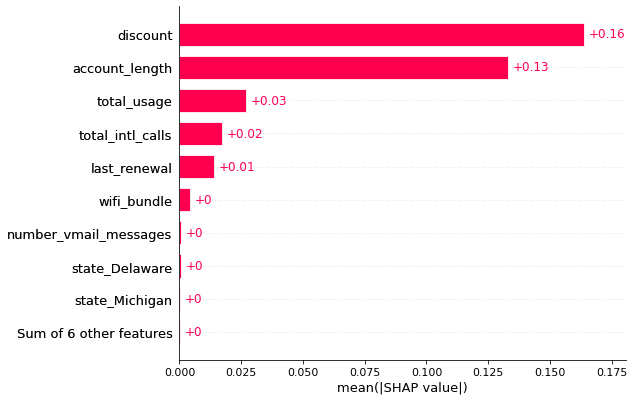

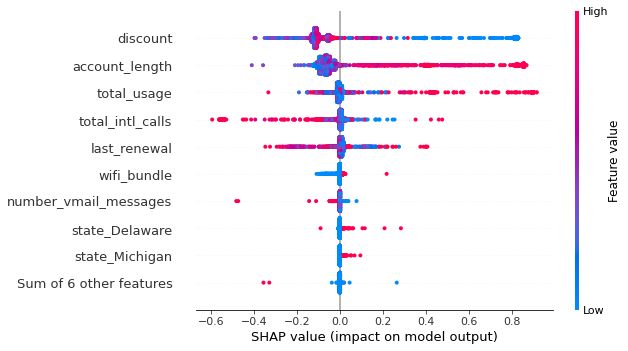

In [45]:
# feature importance (global)

# bar chart
shap.plots.bar(shap_values)

# individual dots for each instance
shap.plots.beeswarm(shap_values)

> **Note:** Discount and account length are the top variables contributing to churn prediction, with discount having the highest SHAP value. Total usage, total international calls, and best renewal are also significant variables in predicting churn.

> 1. Discount: Higher discounts have been observed to lower customer churn. The plot indicates that an increase in discounts leads to a decrease in churn. There are more observations clustered around an average value of 0.8, showing that higher discounts are associated with lower churn.
> 2. Account Length: The length of time since the account was opened has a significant impact on churn probability. It is evident that older customers, or those with a longer account history, have a higher probability of churning.
> 3. Total Usage: The SHAP value for "Monthly Average" suggests that as the monthly average usage increases, it positively influences the probability of customer churn. In other words, customers who have a higher monthly average usage tend to churn more frequently as their usage increases.
> 4. Last Renewal: If the duration between the last contract renewal and the current day is longer, it has a positive impact on predicting customer churn. This implies that customers who have recently renewed their contracts are less likely to churn.
> 5. State (Michigan, Delaware): Customers from specific states, such as Michigan and Delaware, have a higher probability of churning compared to customers from other states.
> 6. Voicemail (Vmail): The probability of churn increases when the number of voicemail messages is lower. Customers who receive fewer voicemail messages are more likely to churn.

> In summary, the variables that contribute most to churn prediction are: higher discounts, longer account length, increased total usage, longer duration since the last renewal, being from specific states like Michigan and Delaware, and receiving fewer voicemail messages.

In [127]:
# Set up kernel explainer for ".predict_proba" method
explainer = shap.KernelExplainer(best_model_gbt.predict_proba, shap.sample(X_train, 30))

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

  0%|          | 0/5120 [00:00<?, ?it/s]

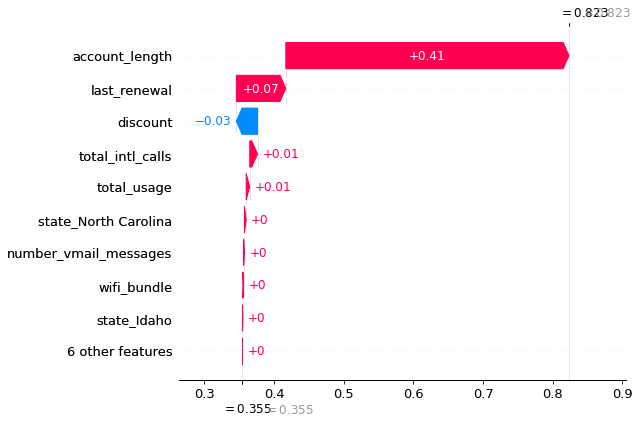

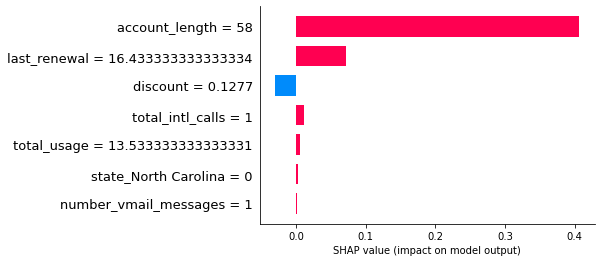

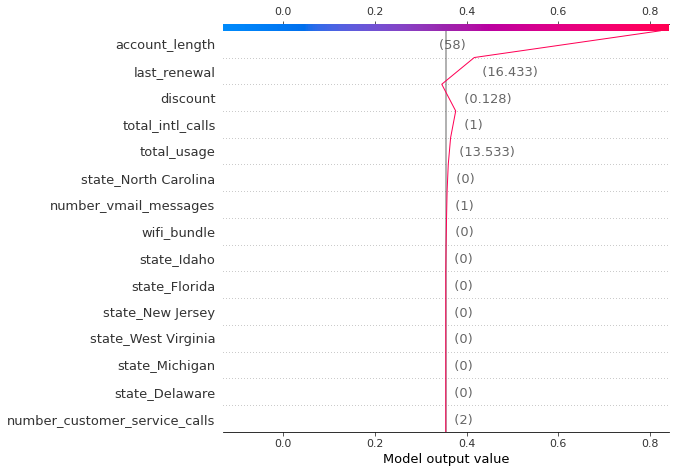

In [129]:
# Feature importance for individual instances (and class)

target = 1
instance = 0

# inspect feature contributions for individual instances
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[target], shap_values[target][instance], feature_names=X_train.columns)

# bar plot for individual instances
shap.bar_plot(shap_values[target][instance], X_train.iloc[instance])

# decision plot for individual instances
shap.decision_plot(explainer.expected_value[target], shap_values[target][instance], X_train)

shap.force_plot(explainer.expected_value[target], shap_values[target][instance], X_train.iloc[instance])

> **Note:** In the specific instance where the predicted probability of customer churn is 82.3%.

> The churn probability of a customer remains constant at 35.5% (considered as the non-churn class in the begining) if they are not from Delaware, Virginia, Florida, New Jersey, and some other states. However, the probability of churn slightly increases with factors such as having one international call and a monthly average usage of 13.53. This increase is offset by the presence of a discount, which lowers the churn probability below the original 35.5% level.

> On the other hand, variables like account length and last_renewal have a significant impact on the churn probability. Account length contributes to a 40% positive change in the customer churn probability. 
this variables significantly increase the probability of churn, leading to a drastic jump in the overall churn probability. Similarly, last_renewal has a 7% impact on customer churn.

### 3. Top 25% of Churners

Assumin that, the company is interested in the top 25% of churners present in the new dataset, in this case, test data.

In [130]:
# Top 25% of churners
y_pred_prob = best_model_gbt.predict_proba(X_test)[:, 1]
threshold = np.percentile(y_pred_prob, 75)
top_25_churners = X_test[y_pred_prob >= threshold]

In [131]:
top_25_churners.head()

account_length  total_usage  last_renewal  wifi_bundle  discount  \
4684            51.0     9.350000     10.200000          0.0    0.1913   
4521            58.0     7.733333      6.766667          0.0    0.0745   
576             58.0     2.900000     11.600000          0.0    0.2224   
7487            36.0     6.000000      4.200000          0.0    0.2490   
6033            12.0     1.600000      1.600000          0.0    0.0039   

      total_intl_calls  number_customer_service_calls  state_Delaware  \
4684               1.0                              1               0   
4521               0.0                              4               0   
576                0.0                              1               0   
7487               2.0                              1               0   
6033               2.0                              1               0   

      state_Michigan  state_West Virginia  state_North Carolina  state_Idaho  \
4684               0                    0                     0            0   
4521               0                    0                     0            0   
576                0                    0                     0            0   
7487               0                    1                     0            0   
6033               0                    0                     0            0   

      state_New Jersey  state_Florida  number_vmail_messages  
4684                 0              0                    0.0  
4521                 0              0                    2.0  
576                  0              0                    1.0  
7487                 0              0                    0.0  
6033                 0              0                    1.0

#### PDP

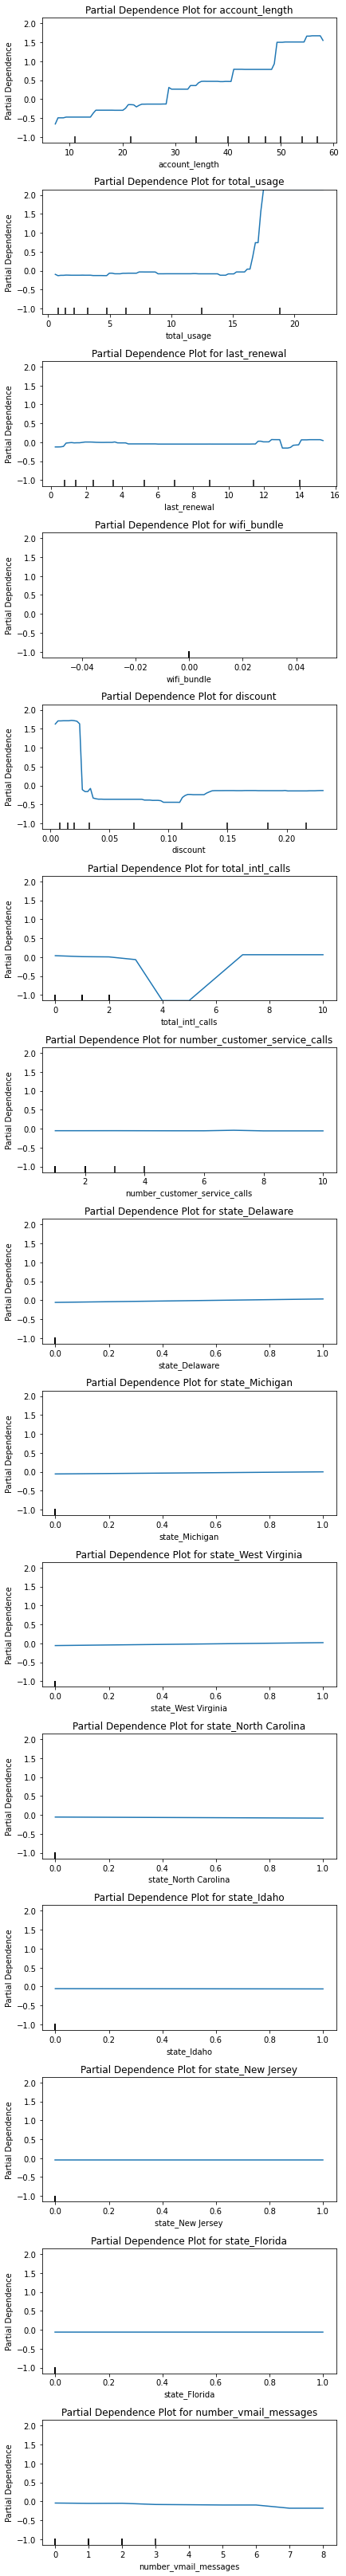

In [96]:
# Partial plot for top 15 features 

#feature_names = top_15_features
feature_names = [
    'account_length',
    'total_usage',
    'last_renewal',
    'wifi_bundle',
    'discount',
    'total_intl_calls',
    'number_customer_service_calls',
    'state_Delaware',
    'state_Michigan',
    'state_West Virginia',
    'state_North Carolina',
    'state_Idaho',
    'state_New Jersey',
    'state_Florida',
    'number_vmail_messages'
]

fig, ax = plt.subplots(len(feature_names), 1, figsize=(6, len(feature_names) * 3))
plot_partial_dependence(best_model_gbt, top_25_churners, features=list(range(0, len(feature_names))), feature_names=feature_names, ax=ax)

# Set the title and axis labels for each subplot
for i, feature_name in enumerate(feature_names):
    ax[i].set_title(f'Partial Dependence Plot for {feature_name}')
    ax[i].set_xlabel(feature_name)
    ax[i].set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

**Note:**
- Account length is positively correlated with the target variable "churn". The longer the length of the account, i.e., the higher the LOR (Length of Relationship) of the customer, the higher the probability of churn. We also notice that the plot has a step-like shape due to the tree-based model used.
- Total usage: As total usage increases, the probability of churn also increases. We can observe that if the average monthly usage is more than 15, the customer is highly likely to churn, as indicated by the sudden rise in the curve.
- Last renewal: The impact of the last renewal on churn is not very clear. There is no churn until 12 days, after which we can see a slight increase in the probability of customer churn. However, the curve then drops down, making it difficult to determine a clear relationship.
- Discount: We can observe that higher discount rates are associated with lower churn probabilities. The churn probability is high for very low discounts but stabilizes after reaching a certain discount value.
- Total international calls: There is no clear impact on customer churn. We see that if the number of international calls is around 4 to 6, the churn probability is very low. However, there is a slight increase in churn probability beyond this range, indicating a slight rise in churn probability.
- Number of customer service calls: There are no significant fluctuations in churn probabilities with an increase in the number of customer service calls.
- States like Delaware, Michigan, and West Virginia show a slight positive impact on churn probabilities if customers are from these places. However, the churn probabilities for the rest of the states do not show any significant variations.
- Number of voicemail messages: The churn probability remains constant even with an increase in the number of messages until 6. After that, there is a slight drop in churn probability.


#### 2D Plot

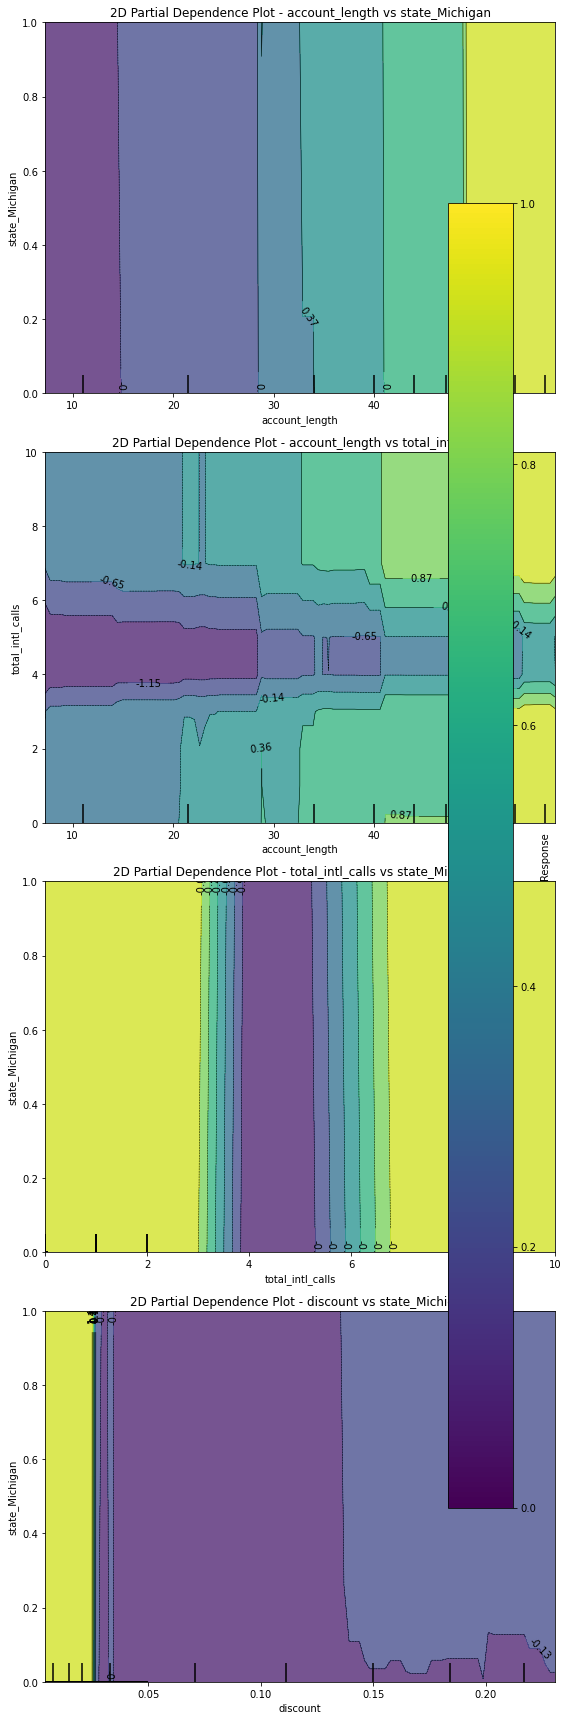

In [60]:
# Define the feature combinations for the 2D partial dependence plots
feature_combinations = [(0, 8), (0, 5), (5, 8), (4, 8)]  # Example feature indices

# Plot the 2D partial dependence plots
fig, ax = plt.subplots(len(feature_combinations), 1, figsize=(8, len(feature_combinations) * 6))

for i, feature_pair in enumerate(feature_combinations):
    plot_partial_dependence(best_model_gbt, top_25_churners, features=[feature_pair], feature_names=feature_names, ax=ax[i])

    # Set the title and axis labels for each subplot
    ax[i].set_title(f'2D Partial Dependence Plot - {feature_names[feature_pair[0]]} vs {feature_names[feature_pair[1]]}')
    ax[i].set_xlabel(feature_names[feature_pair[0]])
    ax[i].set_ylabel(feature_names[feature_pair[1]])

# Add a color legend
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Response')

plt.tight_layout()
plt.show()

#### ICE

Text(0.5, 0.98, 'boosting 25% churners')

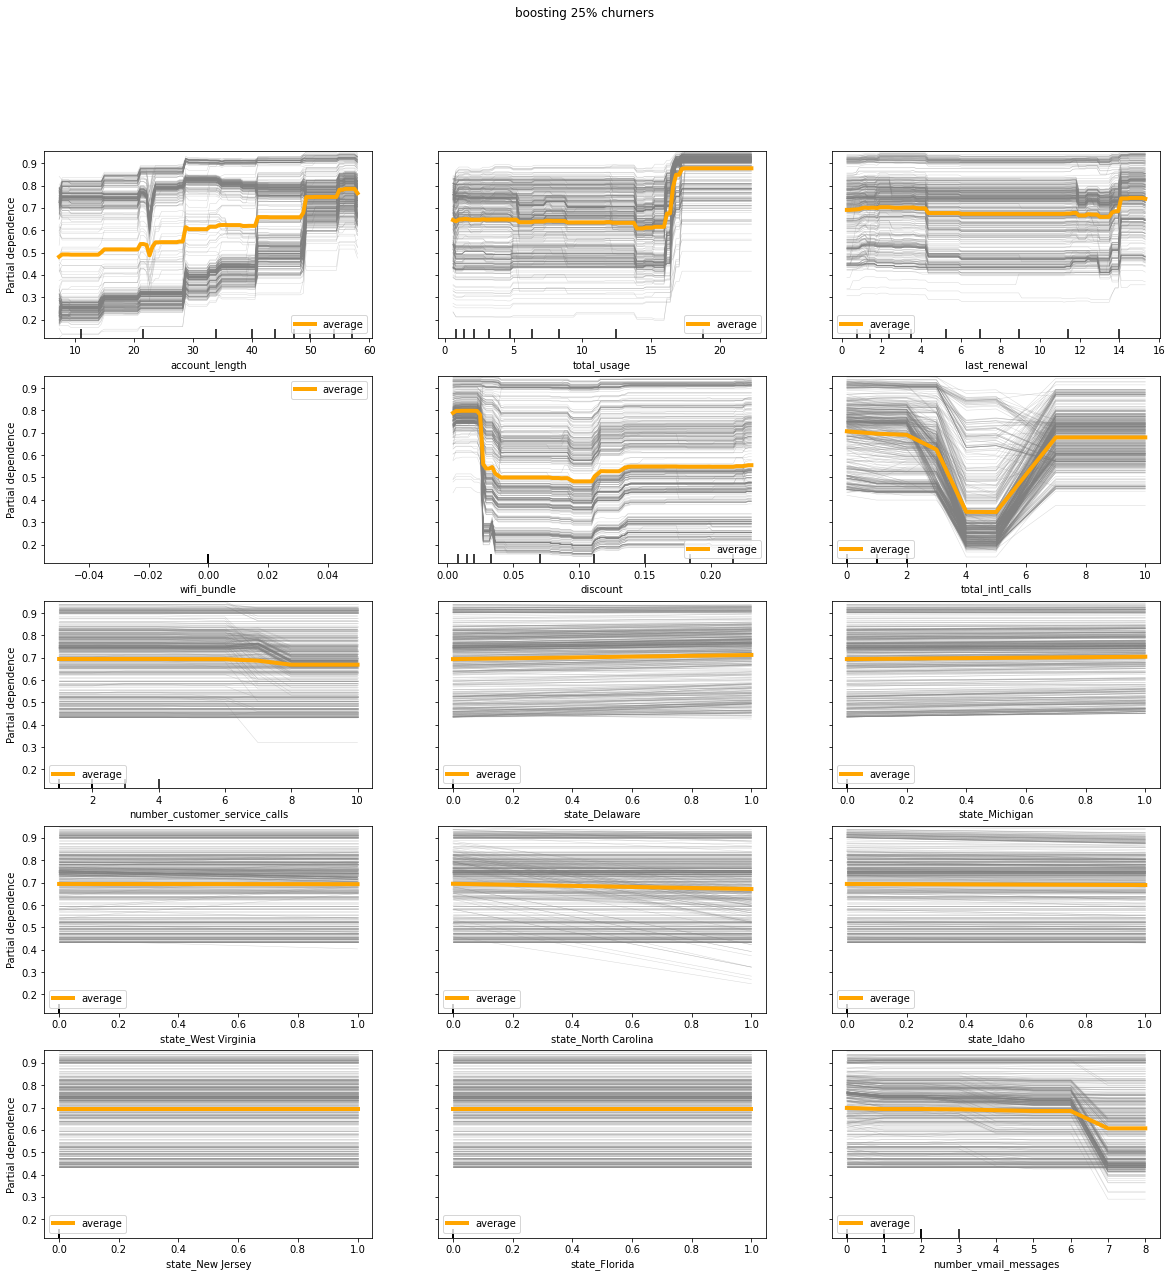

In [128]:
fig, ax = plt.subplots(figsize=(20, 20))
PartialDependenceDisplay.from_estimator(
    estimator=best_model_gbt,
    X=top_25_churners,
    features=list(range(0, len(feature_names))),
    #target=list(iris.target_names).index(target_name),
    kind="both",
    ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
    pd_line_kw={"color": "#ffa500", "linewidth": 4, "alpha":1},
    # centered=True,
    ax=ax
    )
#fig.tight_layout(pad=2.0)
fig.suptitle("boosting 25% churners")

**Note:**

 all ICE plots validates the partial dependence plots , it clrealy follws the excat same patterns of graphs
 
- Account length is positively correlated with the target variable "churn". The longer the length of the account, i.e., the higher the LOR (Length of Relationship) of the customer, the higher the probability of churn. We also notice that the plot has a step-like shape due to the tree-based model used.

- Total usage: As total usage increases, the probability of churn also increases. We can observe that if the average monthly usage is more than 15, the customer is highly likely to churn, as indicated by the sudden rise in the curve.

- Last renewal: The impact of the last renewal on churn is not very clear. There is no churn until 12 days, after which we can see a slight increase in the probability of customer churn. However, the curve then drops down, making it difficult to determine a clear relationship.

- Discount: We can observe that higher discount rates are associated with lower churn probabilities. The churn probability is high for very low discounts but stabilizes after reaching a certain discount value.

- Total international calls: There is no clear impact on customer churn. We see that if the number of international calls is around 4 to 6, the churn probability suddenly drops to  very low. However, there is a slight increase in churn probability beyond this range, indicating a slight rise in churn probability. 

- Number of customer service calls: There are no significant fluctuations in churn probabilities with an increase in the number of customer service calls.

- States like Delaware, Michigan, and West Virginia show a slight positive impact on churn probabilities if customers are from these places. However, the churn probabilities for the rest of the states do not show any significant variations.

- Number of voicemail messages: The churn probability remains constant even with an increase in the number of messages until 6. After that, there is a slight drop in churn probability.


#### LIME

In [133]:
categorical_features = ["wifi_bundle", "state_Michigan", "state_Delaware","state_West Virginia","state_North Carolina", 
                        "state_Idaho", "state_New Jersey", "state_Florida"]
categorical_features = [list(top_25_churners.columns).index(i) for i in categorical_features]

#class_names = [" churn=0", "non churn=1"]

# Initialize explainer
explainer = lime_tabular.LimeTabularExplainer(
    top_25_churners.values,
    discretize_continuous=True,
    feature_names=list(top_25_churners.columns),
    mode="classification",
    sample_around_instance=True
    )

# Explain first instance in test set
exp = explainer.explain_instance(top_25_churners.iloc[1], best_model_gbt.predict_proba,num_features=len(top_25_churners.columns))
exp.show_in_notebook(show_table=True, show_all=True)

> **Note:**  The above image shows three graphs that each show essential information about customers and their churn rates:
> - The left graph shows that sample 1 in the data shows the confidence interval stating that this instance is 66% Churn. The highest importance score of 20% is attributed to the "account length" feature, indicating that it significantly contributes positively to the predicted churn probability. Following closely is the "total_international_calls" feature with a score of 12%. Interestingly, if customers are not from Florida, it has a positive impact on reducing the churn probability.
On the other hand, certain states such as Idaho, New Jersey, Delaware, and others have negative importance scores, indicating that they contribute to a higher churn probability if  Customers from these states. Additionally, the graph highlights that higher discounts have a negative impact on churn, with a 10% reduction in churn probability. Furthermore, for  the total usage is less than 4.70,  reduces the  probability of churn.
> - In the right graph, the 15 features and their respective values are displayed. The features highlighted in orange contribute to class 1 (Churn), while the features highlighted in blue contribute to class 0 (Not Churn).


In [138]:
# Display Model prediction vs LIME prediction
pd.DataFrame(
    [exp.local_pred.item(), exp.predict_proba[1]],
    index=["LIME Prediction", "Model Prediction"],
    columns=["Probability"]
    )

Probability
LIME Prediction      0.613118
Model Prediction     0.662440

**Explanation:** 
Comparing the LIME prediction and the model prediction, there is no signifcant differnece b/w the probablities
 indicates that this particular instance belongs to churn class

In [135]:
# Display coefficients of LIME local regression model

# Sort coefficients according to index  
coef = exp.local_exp[1]
coef = sorted(coef)

In [136]:
# Create dataframe and merge intercept
df_coef = pd.DataFrame([i[1] for i in coef], columns=["beta"], index=X_train.columns)
df_coef = pd.concat((df_coef, pd.Series(exp.intercept[1], index=["INTERCEPT"], name="beta").to_frame()))

df_coef

beta
account_length                 0.197032
total_usage                   -0.066989
last_renewal                  -0.023087
wifi_bundle                    0.000000
discount                      -0.096606
total_intl_calls               0.118566
number_customer_service_calls -0.018754
state_Delaware                -0.000122
state_Michigan                 0.010973
state_West Virginia            0.019764
state_North Carolina           0.001727
state_Idaho                   -0.023246
state_New Jersey              -0.041535
state_Florida                  0.026473
number_vmail_messages         -0.011035
INTERCEPT                      0.519956

**Explanation:** The beta values represent the weights or coefficients assigned to each feature in the LIME explanation. These weights indicate the contribution of each feature towards the predicted outcome. By considering the feature weights, we can see that account_length has the highest and a positive impact on the prediction, followed by total_usage. On the other hand, state_West Virginia has the highest negative impact on customer churn.

In [137]:
# Display attribution table
pd.DataFrame(exp.as_list(),columns=['Feature','Attribution'])

Feature  Attribution
0                 account_length > 52.00     0.197032
1               total_intl_calls <= 1.00     0.118566
2                0.07 < discount <= 0.16    -0.096606
3             4.70 < total_usage <= 9.80    -0.066989
4               state_New Jersey <= 0.00    -0.041535
5                  state_Florida <= 0.00     0.026473
6                    state_Idaho <= 0.00    -0.023246
7            5.25 < last_renewal <= 9.80    -0.023087
8            state_West Virginia <= 0.00     0.019764
9   number_customer_service_calls > 3.00    -0.018754
10  1.00 < number_vmail_messages <= 2.00    -0.011035
11                state_Michigan <= 0.00     0.010973
12          state_North Carolina <= 0.00     0.001727
13                state_Delaware <= 0.00    -0.000122
14                   wifi_bundle <= 0.00     0.000000

#### SHAP

Permutation explainer: 502it [01:59,  3.80it/s]                                                                        


shap.explainers.Permutation()


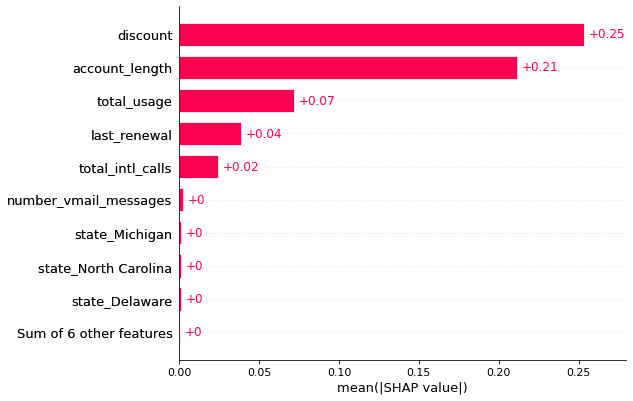

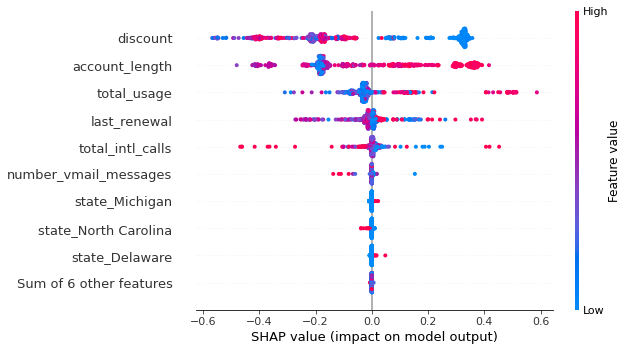

In [104]:
# Set up explainer for ".predict" method
explainer = shap.Explainer(best_model_gbt.predict, top_25_churners)

# Compute shap values
shap_values = explainer(top_25_churners)


# check explainer type
print(str(explainer)) # make sure your are using the intended explainer

# check explainer type
print(str(explainer.masker))

# feature importance (global)

# bar chart
shap.plots.bar(shap_values)

# individual dots for each instance
shap.plots.beeswarm(shap_values)

> **Note:** From the baove plot we can see that discount, account_length, total_usage, total_renewal are the top variables with 
discount and accountlength having values of 0.25 and 0.21 respectively. On the states, Michegan is still on top follwed by carolina and Delaware.

> **Model Impact:**
> 1. Discount: A high positive SHAP value for the "Discount" feature indicates that providing more discounts has a high impact on reducing customer churn. It suggests that customers are more likely to stay for a longer duration if they receive more discounts. Conversely, a low or negative SHAP value for "Discount" implies that the absence or reduced availability of discounts impacts churn negatively, increasing the likelihood of customers churning.
> 2. Account Length:  A positive SHAP value for "Account Length" indicates that, after a certain period since the account opening, customers tend to churn more. This suggests that long-term customers may become more likely to churn over time. 
> 3. Monthly Average:  A positive SHAP value for "Monthly Average" suggests that, as the monthly average increases, it positively impacts the probability of customer churn. This implies that a higher monthly average may lead to more churners, potentially indicating dissatisfaction or a shift in customer behavior.
> 4. Last Renewal: A low SHAP value for "Last Renewal" indicates that it has a relatively low impact on churn. However, as the SHAP value increases beyond a certain threshold (around 0.2 ), it positively impacts the probability of customer churn. This suggests that if the last renewal date is further in the past, it may increase the likelihood of churn. 
> 5. State (Michigan, Delaware, and North Carolina):  positive SHAP value for states like Michigan and Delaware indicates that customers from these states have a higher impact on the probability of churn. This implies that customers from these states are more likely to churn. On the other hand, a low or negative SHAP value for North Carolina suggests that customers from this state have a lower impact on churn probability, indicating a comparatively lower churn rate.

> All other variables are distributed around zero shap/ low values, which indiactes they contribute less to churn of customer. 

> Based on the analysis of SHAP values, our findings suggest that providing more discounts can significantly reduce customer churn, while variables such as account length, monthly average, last renewal date, and customer location play a role in influencing churn probability.

In [100]:
# Set up kernel explainer for ".predict_proba" method
explainer = shap.KernelExplainer(best_model.predict_proba, shap.sample(top_25_churners, 30))

# Compute SHAP values
shap_values = explainer.shap_values(top_25_churners)

  0%|          | 0/501 [00:00<?, ?it/s]

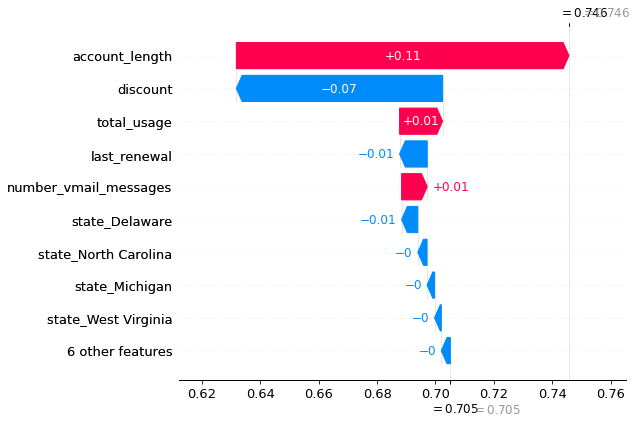

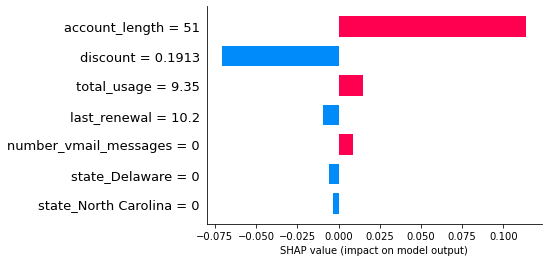

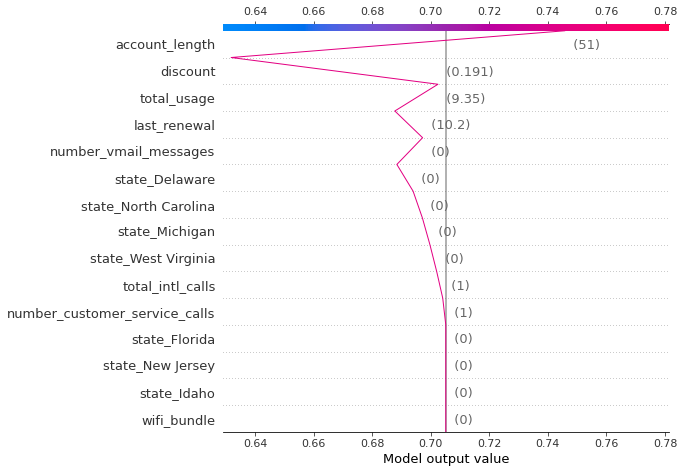

In [103]:
# feature importance for individual instances (and class)

target = 1
instance = 0

# inspect feature contributions for individual instances
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[target], shap_values[target][instance], feature_names=top_25_churners.columns)

# bar plot for individual instances
shap.bar_plot(shap_values[target][instance], top_25_churners.iloc[instance])

# decision plot for individual instances
shap.decision_plot(explainer.expected_value[target], shap_values[target][instance], top_25_churners)

#shap.force_plot(explainer.expected_value[target], shap_values[target][instance], top_25_churners.iloc[instance])

> **Note:** In the specific instance  where the predicted probability of customer churn is 0.746, we observe that the churn probability fluctuates around 0.70 for variables such as the number of service calls and whether the customer is from states like Florida, New Jersey, or Idaho. However, there is a noticeable decrease in the churn probability to 0.64 if the customer is not from the states of Delaware, Carolina, or Michigan. Factors like the number of mail messages and total usage have a positive impact on the churn probability, increasing it by up to 0.70. On the other hand, adding a discount to the customer's account leads to a negative SHAP value, indicating a decrease in the churn probability to 0.64. The most significant factor influencing the churn probability in this instance is the account length, with a sharp increase in churn probability from 0.64 to 0.74 for an account length of 51 months.
Overall, factors such as account length, discounts, the number of mail messages, total usage, and the customer's state play crucial roles in determining the churn probability for this specific instance


### Comparision LOGIT vs. GBT  and Final Business Conclusions on 25% of Churners

**Comparison**
> - account_length is the biggest contributor for the LOGIT model whereas for the GBT model it is discount.
> - Being a resident of Michigan had an impact for the LOGIT model. The 2D PDP plot shows us that for any given account_length the probability of churn is higher for a Michigan resident than a resident from any other state. That is not the case in the GBT model. Being a Michigan resident doens't impact the results.
> - The ICE plots for the LOGIT model does a good job at catching all the trends in the data but for some variables of the GBT model it didn't manage to capture all of it.
> - PDP: Discount had a steady decrease for the LOGIT model but for the GBT model it initially had a huge drop and then stabilises over the rest of the plot.
> - for the specific instances, local  feature importances of the LR and boosting models generated by shap and Lime varies. 
 result from boosting model tends to  ahve churn predictabilty and high coefficient values assigned for the same varibles like account length, discounts than LR model
>- there is sifnigicant difference Global average  shap coeficents assigned to each varible and their  impact on the churn prediction for logistic and boosting ,
  

**Business Conclusions top 25% churners**
> - Focus on nurturing the relations with long-term customers. They are the once that are churning the most.
> - Offer discounts to these customers. A 19% discount reduces the churn probability by 5%.
> - Target specific states as residents from some states like  Michigan, Delaware,are more likely to churn than others. 
>- focous on monthly average usage of customers, higher the avg monthly  more that customer churn
>- make sure to  have clear track on the contract renewal, and provide some discounts at the time of expiry of contacts
>- focous on customer who makes more intenational calss and provide addidtional beniftis, as they tend to churn more

### THANK YOU!